In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2024-02-01 07:35:00.793828: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 07:35:01.652690: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-01 07:35:01.652775: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-02-01 07:35:01.652783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
# load data
data_path = '/home/hpinkard_waller/data/DINO_debugging/'
background = 50
photons_per_pixel = 400
patch_size = 39
sample = 'full_volume'

# learned_lens_data = np.load(data_path + 'full_volume_learned_lens.npy')
single_lens_data = np.load(data_path + 'full_volume_single_lens.npy')
double_lens_data = np.load(data_path + 'full_volume_double_lens.npy')
many_lens_data = np.load(data_path + 'full_volume_many_lens.npy')

# single_lens_data = single_lens_data / single_lens_data.mean() * photons_per_pixel
# double_lens_data = double_lens_data / double_lens_data.mean() * photons_per_pixel
many_lens_data = many_lens_data / many_lens_data.mean() * photons_per_pixel
learned_lens_data = learned_lens_data / learned_lens_data.mean() * photons_per_pixel

# single_lens_data += background
# double_lens_data += background
many_lens_data += background
learned_lens_data += background

# data_min = min(single_lens_data.min(), double_lens_data.min(), many_lens_data.min(), learned_lens_data.min())
# data_max = max(single_lens_data.max(), double_lens_data.max(), many_lens_data.max(), learned_lens_data.max())

data_min = min(many_lens_data.min(), learned_lens_data.min())
data_max = max(many_lens_data.max(), learned_lens_data.max())

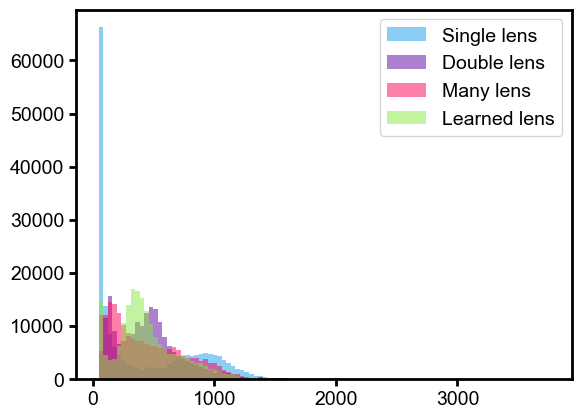

In [3]:
# plot histograms
fig, ax = plt.subplots()
hist_max = max(np.percentile(single_lens_data, 99.5), np.percentile(double_lens_data, 99.5), np.percentile(many_lens_data, 99.5), np.percentile(learned_lens_data, 99.5))

bins = np.linspace(data_min, data_max, 100)
_ = ax.hist(single_lens_data[:8].ravel(), bins=bins, label='Single lens', alpha=0.5)
_ = ax.hist(double_lens_data[:8].ravel(), bins=bins, label='Double lens', alpha=0.5)
_ = ax.hist(many_lens_data[:8].ravel(), bins=bins, label='Many lens', alpha=0.5)
_ = ax.hist(learned_lens_data[:8].ravel(), bins=bins, label='Learned lens', alpha=0.5)
ax.legend()

Text(-30, 80, 'Learned lens')

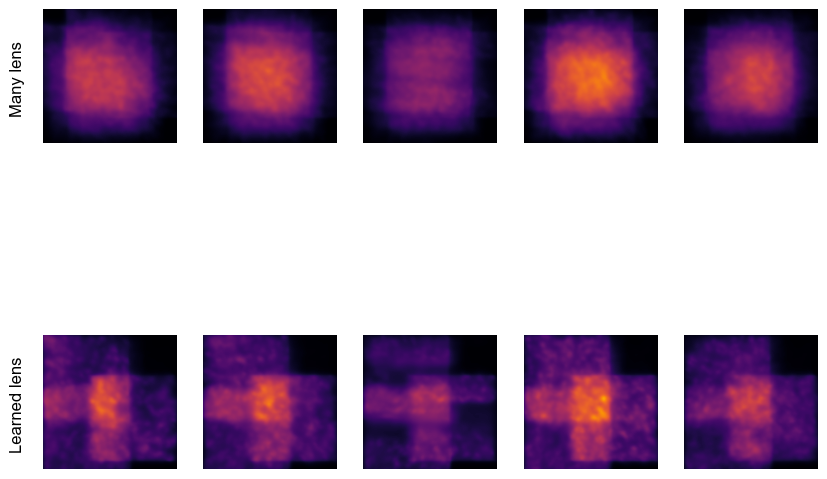

In [4]:
# vmin = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data, learned_lens_data]), 1)
# vmax = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data, learned_lens_data]), 99)

vmin = np.percentile(np.stack([many_lens_data, learned_lens_data]), 1)
vmax = np.percentile(np.stack([many_lens_data, learned_lens_data]), 99)

fig, axs = plt.subplots(3, 5, figsize=(10, 6))

for i in range(5):
    # axs[0, i].imshow(single_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    # axs[1, i].imshow(double_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[0, i].imshow(many_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[2, i].imshow(learned_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    # if i != 0:
    #     axs[0, i].axis('off')
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')

# add text identifying the images to the left of the first column
# axs[0, 0].text(-30, 80, 'Single lens', fontsize=12, ha='center', va='center', rotation=90)
# axs[1, 0].text(-30, 80, 'Double lens', fontsize=12, ha='center', va='center', rotation=90)
axs[0, 0].text(-30, 80, 'Many lens', fontsize=12, ha='center', va='center', rotation=90)
axs[2, 0].text(-30, 80, 'Learned lens', fontsize=12, ha='center', va='center', rotation=90)

In [5]:
def extract_uniform_patches(data, patch_size, num_patches, verbose=False):
    """
    Extract patches from data with uniform random sampling
    """
    image_shape = data.shape[1:]
    if image_shape[0] % patch_size != 0 or image_shape[1] % patch_size != 0:
        raise ValueError('Patch size must evenly divide image size')
    num_blocks = image_shape[0] // patch_size
    blocks = []
    for i in range(num_blocks):
        for j in range(num_blocks):
            block = data[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            blocks.append(block)
    blocks = np.concatenate(blocks, axis=0)
    # take a random subset of them as patches
    indices = onp.random.choice(blocks.shape[0], num_patches, replace=False)
    return blocks[indices]


def extract_uniform_patches_with_padding(data, patch_size, num_patches, verbose=False):
    # pad the edges with patch_size pixels with the minimum value 
    pad_width = ((0, 0), (patch_size, patch_size), (patch_size, patch_size))
    padded_data = np.pad(data, pad_width, mode='constant', constant_values=data.min())

    # generate random center locations within the data
    image_indices = onp.random.choice(data.shape[0], num_patches, replace=True)
    random_yx_locations = onp.random.randint(patch_size, data.shape[1] + patch_size, (num_patches, 2))

    patches = []
    for i, (image_index, (y, x)) in enumerate(zip(image_indices, random_yx_locations)):
        patch = padded_data[image_index, y-patch_size // 2:y+patch_size // 2, x-patch_size // 2:x+patch_size // 2]
        patches.append(patch)

    return np.array(patches)
    


# Generate and train

100%|██████████| 10/10 [00:00<00:00, 118.73it/s]


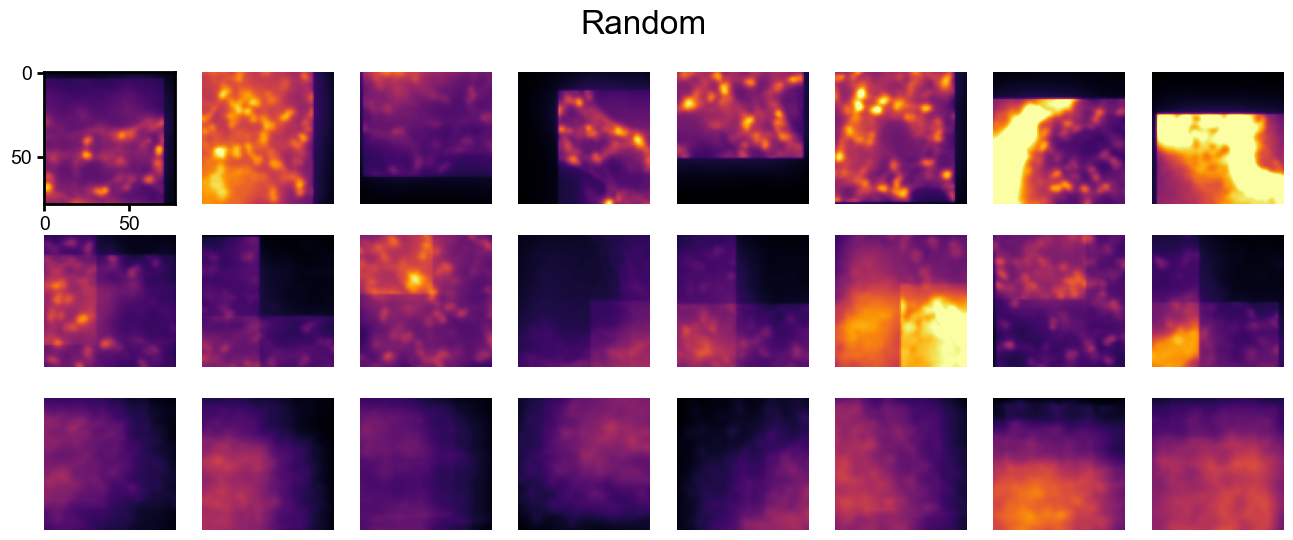

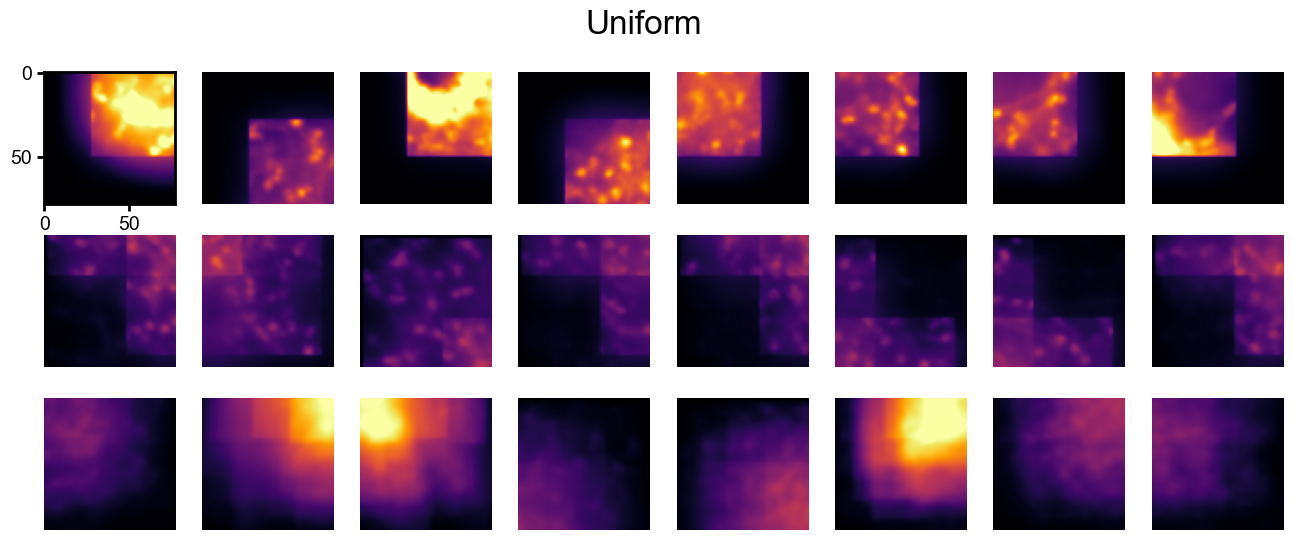

In [3]:
# plot uniform vs center biased patches

# vmin = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 1)
# vmax = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 99)


# for uniform in [False, True]:

#     if uniform:
#         single_lens_patches = extract_uniform_patches(single_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
#         double_lens_patches = extract_uniform_patches(double_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
#         many_lens_patches = extract_uniform_patches(many_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
#     else:
#         single_lens_patches = extract_patches(single_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
#         double_lens_patches = extract_patches(double_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
#         many_lens_patches = extract_patches(many_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        

#     fig, axs = plt.subplots(3, 8, figsize=(16, 6))

#     for i in range(8):
#         axs[0, i].imshow(single_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
#         axs[1, i].imshow(double_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
#         axs[2, i].imshow(many_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
#         if i != 0:
#             axs[0, i].axis('off')
#         axs[1, i].axis('off')
#         axs[2, i].axis('off')
#     fig.suptitle('Uniform' if uniform else 'Random')

In [6]:
num_patches = 5000

for i in range(20):

    # single_lens_patches = extract_uniform_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    # double_lens_patches = extract_uniform_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    # many_lens_patches = extract_uniform_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    # learned_lens_patches = extract_uniform_patches(learned_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)

    # single_lens_patches = extract_uniform_patches_with_padding(single_lens_data, patch_size=patch_size, num_patches=num_patches, verbose=True)
    # double_lens_patches = extract_uniform_patches_with_padding(double_lens_data, patch_size=patch_size, num_patches=num_patches, verbose=True)
    many_lens_patches = extract_uniform_patches_with_padding(many_lens_data, patch_size=patch_size, num_patches=num_patches, verbose=True)
    learned_lens_patches = extract_uniform_patches_with_padding(learned_lens_data, patch_size=patch_size, num_patches=num_patches, verbose=True)

    # single_lens_noisy_patches = add_noise(single_lens_patches)
    # double_lens_noisy_patches = add_noise(double_lens_patches)
    many_lens_noisy_patches = add_noise(many_lens_patches)
    learned_lens_noisy_patches = add_noise(learned_lens_patches)

    # single_lens_mi_pcnn = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches,entropy_model='pixel_cnn', verbose=True)
    # double_lens_mi_pcnn = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches, entropy_model='pixel_cnn', verbose=True)
    many_lens_mi_pcnn = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches, entropy_model='pixel_cnn', verbose=True)
    learned_lens_mi_pcnn = estimate_mutual_information(learned_lens_noisy_patches, clean_images=learned_lens_patches, entropy_model='pixel_cnn', verbose=True)

    # # do gaussian
    # single_lens_mi_gaussian = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches, verbose=True)
    # double_lens_mi_gaussian = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches, verbose=True)
    # many_lens_mi_gaussian = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches, verbose=True)


    def get_next_suffix(path):
        if not os.path.exists(path):
            return 0
        else:
            return len([f for f in os.listdir(path)])
        
    def save_data(data, gaussian_or_pcnn, lens):
        saving_path = [gaussian_or_pcnn, sample, lens, f'{photons_per_pixel}_photons', f'{background}_background']
        full_path = os.sep.join([data_path] + saving_path)
        # make this directory if it doesn't exist, creating intermediate directories as necessary
        os.makedirs(full_path, exist_ok=True)
        suffix = get_next_suffix(full_path)
        np.save(os.path.join(full_path, f'patch_{patch_size}_{suffix}.npy'), data)


    # save_data(single_lens_mi_pcnn, 'pcnn', 'single_lens')
    # save_data(double_lens_mi_pcnn, 'pcnn', 'double_lens')
    save_data(many_lens_mi_pcnn, 'pcnn', 'many_lens')
    save_data(learned_lens_mi_pcnn, 'pcnn', 'learned_lens')

Initial validation NLL: 277.82


Epoch 1: 100%|██████████| 100/100 [00:13<00:00,  7.40it/s]


Epoch 1: validation NLL: 6.10


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.72it/s]


Epoch 2: validation NLL: 5.78


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.66it/s]


Epoch 3: validation NLL: 5.11


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.61it/s]


Epoch 4: validation NLL: 5.16


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.57it/s]


Epoch 5: validation NLL: 5.95


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.56it/s]


Epoch 6: validation NLL: 4.87


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.52it/s]


Epoch 7: validation NLL: 5.94


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 8: validation NLL: 5.56


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.44it/s]


Epoch 9: validation NLL: 4.73


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 10: validation NLL: 4.61


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 11: validation NLL: 4.64


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 12: validation NLL: 4.50


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


Epoch 13: validation NLL: 4.49


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


Epoch 14: validation NLL: 4.53


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch 15: validation NLL: 4.72


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch 16: validation NLL: 4.48


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 17: validation NLL: 4.45


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 18: validation NLL: 4.49


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 19: validation NLL: 4.44


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 20: validation NLL: 4.43


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 21: validation NLL: 4.42


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 22: validation NLL: 4.95


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 23: validation NLL: 4.67


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 24: validation NLL: 4.43


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 25: validation NLL: 4.47


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 26: validation NLL: 4.45


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 27: validation NLL: 4.51


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 28: validation NLL: 4.41


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 29: validation NLL: 4.40


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 30: validation NLL: 4.42


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 31: validation NLL: 4.41


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 32: validation NLL: 4.40


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 33: validation NLL: 4.56


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 34: validation NLL: 4.46


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 35: validation NLL: 4.41


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 36: validation NLL: 4.53


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 37: validation NLL: 4.45


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 38: validation NLL: 4.44


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 39: validation NLL: 4.39


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 40: validation NLL: 4.42


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 41: validation NLL: 4.45


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 42: validation NLL: 4.43


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 43: validation NLL: 4.47


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 44: validation NLL: 4.39


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 45: validation NLL: 4.45


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 46: validation NLL: 6.56


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 47: validation NLL: 5.80


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 28.30it/s]


Epoch 48: validation NLL: 6.67


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch 49: validation NLL: 6.61


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 50: validation NLL: 6.86


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 51: validation NLL: 6.85


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 52: validation NLL: 6.85


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 53: validation NLL: 6.85


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 54: validation NLL: 6.85


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 55: validation NLL: 6.85


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 56: validation NLL: 6.85


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 57: validation NLL: 6.85


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 58: validation NLL: 6.85


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 59: validation NLL: 6.85


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 28.43it/s]


Epoch 60: validation NLL: 6.85


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 28.43it/s]


Epoch 61: validation NLL: 6.85


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 62: validation NLL: 6.85


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 28.43it/s]


Epoch 63: validation NLL: 6.85


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 28.43it/s]


Epoch 64: validation NLL: 6.85


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 65: validation NLL: 6.85


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 66: validation NLL: 6.85


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch 67: validation NLL: 6.85


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 68: validation NLL: 6.85


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 69: validation NLL: 6.85


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 70: validation NLL: 6.85


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch 71: validation NLL: 6.85


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch 72: validation NLL: 6.85


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 73: validation NLL: 6.85


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch 74: validation NLL: 6.85


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 75: validation NLL: 6.85


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 76: validation NLL: 6.85


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 77: validation NLL: 6.85


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 78: validation NLL: 6.85


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 79: validation NLL: 6.85


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 80: validation NLL: 6.85


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 81: validation NLL: 6.85


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 82: validation NLL: 6.85


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 83: validation NLL: 6.85


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 84: validation NLL: 6.85
Estimated H(Y|X) = 4.270 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.435 differential entropy/pixel
Estimated I(Y;X) = 0.238 bits/pixel
Initial validation NLL: 298.95


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.63it/s]


Epoch 1: validation NLL: 6.05


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 2: validation NLL: 5.71


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 3: validation NLL: 4.87


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 4: validation NLL: 5.39


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 5: validation NLL: 4.67


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 6: validation NLL: 4.59


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 7: validation NLL: 4.56


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 8: validation NLL: 4.54


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 9: validation NLL: 4.49


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 10: validation NLL: 4.59


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 11: validation NLL: 4.49


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 12: validation NLL: 4.52


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 13: validation NLL: 4.50


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 14: validation NLL: 4.47


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 15: validation NLL: 4.47


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 16: validation NLL: 4.48


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 17: validation NLL: 4.46


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 18: validation NLL: 4.46


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 19: validation NLL: 4.93


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 20: validation NLL: 4.63


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 21: validation NLL: 4.80


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 22: validation NLL: 4.53


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 23: validation NLL: 4.63


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 24: validation NLL: 4.50


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 25: validation NLL: 4.59


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 26: validation NLL: 4.58


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 27: validation NLL: 4.66


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 28: validation NLL: 4.46


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 29: validation NLL: 4.46


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 30: validation NLL: 4.44


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 31: validation NLL: 4.44


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 32: validation NLL: 4.46


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 33: validation NLL: 4.60


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 34: validation NLL: 4.43


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 35: validation NLL: 4.74


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 36: validation NLL: 4.49


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 37: validation NLL: 5.33


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch 38: validation NLL: 4.87


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch 39: validation NLL: 5.31


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 40: validation NLL: 4.87


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 41: validation NLL: 4.59


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 42: validation NLL: 4.98


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 43: validation NLL: 4.52


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 44: validation NLL: 4.66


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 45: validation NLL: 4.64


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 28.43it/s]


Epoch 46: validation NLL: 4.60


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 28.43it/s]


Epoch 47: validation NLL: 4.67


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 28.44it/s]


Epoch 48: validation NLL: 4.50


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 28.43it/s]


Epoch 49: validation NLL: 4.62


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 28.44it/s]


Epoch 50: validation NLL: 5.10


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 28.43it/s]


Epoch 51: validation NLL: 4.51


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 52: validation NLL: 4.55


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 28.43it/s]


Epoch 53: validation NLL: 4.54


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 28.43it/s]


Epoch 54: validation NLL: 4.48


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 55: validation NLL: 4.49


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 56: validation NLL: 4.54


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 57: validation NLL: 5.60


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch 58: validation NLL: 6.35


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 59: validation NLL: 5.12


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 60: validation NLL: 4.77


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 28.52it/s]


Epoch 61: validation NLL: 4.63


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 28.52it/s]


Epoch 62: validation NLL: 4.55


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 63: validation NLL: 4.51


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 64: validation NLL: 4.50


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 65: validation NLL: 4.60


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


Epoch 66: validation NLL: 4.52


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 67: validation NLL: 4.49


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 68: validation NLL: 4.50


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 69: validation NLL: 4.48


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 70: validation NLL: 4.49


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 71: validation NLL: 4.48


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 72: validation NLL: 4.53


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 73: validation NLL: 4.58


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 74: validation NLL: 4.45
Estimated H(Y|X) = 4.273 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.454 differential entropy/pixel
Estimated I(Y;X) = 0.261 bits/pixel
Initial validation NLL: 302.63


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.71it/s]


Epoch 1: validation NLL: 5.84


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch 2: validation NLL: 6.04


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


Epoch 3: validation NLL: 5.16


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 4: validation NLL: 5.00


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 5: validation NLL: 4.86


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 6: validation NLL: 5.06


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 7: validation NLL: 4.67


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 8: validation NLL: 4.56


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 9: validation NLL: 4.58


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 10: validation NLL: 4.56


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 11: validation NLL: 4.56


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 12: validation NLL: 4.53


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 13: validation NLL: 4.47


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 28.09it/s]


Epoch 14: validation NLL: 4.61


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 28.00it/s]


Epoch 15: validation NLL: 4.81


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 27.99it/s]


Epoch 16: validation NLL: 4.45


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 27.94it/s]


Epoch 17: validation NLL: 4.52


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 27.94it/s]


Epoch 18: validation NLL: 4.45


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 27.99it/s]


Epoch 19: validation NLL: 4.45


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 27.97it/s]


Epoch 20: validation NLL: 4.42


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 27.99it/s]


Epoch 21: validation NLL: 4.50


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 28.00it/s]


Epoch 22: validation NLL: 4.39


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 28.00it/s]


Epoch 23: validation NLL: 4.61


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


Epoch 24: validation NLL: 4.43


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


Epoch 25: validation NLL: 4.46


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 28.05it/s]


Epoch 26: validation NLL: 4.51


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 27: validation NLL: 4.42


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 28.08it/s]


Epoch 28: validation NLL: 4.59


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 28.07it/s]


Epoch 29: validation NLL: 4.42


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 28.10it/s]


Epoch 30: validation NLL: 4.70


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 31: validation NLL: 4.52


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 32: validation NLL: 4.42


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 33: validation NLL: 4.46


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 34: validation NLL: 4.46


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 35: validation NLL: 4.44


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 36: validation NLL: 4.42


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 37: validation NLL: 4.37


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 38: validation NLL: 4.60


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 39: validation NLL: 4.38


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 40: validation NLL: 4.43


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 41: validation NLL: 4.38


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 42: validation NLL: 4.39


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 43: validation NLL: 7.13


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 44: validation NLL: 7.00


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 28.44it/s]


Epoch 45: validation NLL: 6.95


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 46: validation NLL: 6.89


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 47: validation NLL: 6.89


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 48: validation NLL: 6.89


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 49: validation NLL: 6.89


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 50: validation NLL: 6.89


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 51: validation NLL: 6.89


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 52: validation NLL: 6.89


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 53: validation NLL: 6.89


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 54: validation NLL: 6.89


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 55: validation NLL: 6.89


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 56: validation NLL: 6.89


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 57: validation NLL: 6.89


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 58: validation NLL: 6.89


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 59: validation NLL: 6.89


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 60: validation NLL: 6.89


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 61: validation NLL: 6.89


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 62: validation NLL: 6.89


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 63: validation NLL: 6.89


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 64: validation NLL: 6.89


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 65: validation NLL: 6.89


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 66: validation NLL: 6.89


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 67: validation NLL: 6.89


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 68: validation NLL: 6.89


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 69: validation NLL: 6.89


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 70: validation NLL: 6.89


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 71: validation NLL: 6.89


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 72: validation NLL: 6.89


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 73: validation NLL: 6.89


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 74: validation NLL: 6.89


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 75: validation NLL: 6.89


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 76: validation NLL: 6.89


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch 77: validation NLL: 6.89
Estimated H(Y|X) = 4.249 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.402 differential entropy/pixel
Estimated I(Y;X) = 0.221 bits/pixel
Initial validation NLL: 297.28


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.32it/s]


Epoch 1: validation NLL: 6.13


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 2: validation NLL: 5.27


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 3: validation NLL: 4.76


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 4: validation NLL: 4.91


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 5: validation NLL: 5.80


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 6: validation NLL: 4.65


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 7: validation NLL: 4.70


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 8: validation NLL: 4.56


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 9: validation NLL: 4.55


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 10: validation NLL: 4.57


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 11: validation NLL: 4.55


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 12: validation NLL: 4.65


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 13: validation NLL: 4.55


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 14: validation NLL: 4.51


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 15: validation NLL: 4.48


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 16: validation NLL: 4.45


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 17: validation NLL: 4.47


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 18: validation NLL: 4.45


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 19: validation NLL: 4.46


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 20: validation NLL: 4.45


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 21: validation NLL: 4.43


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 22: validation NLL: 4.47


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 23: validation NLL: 4.45


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 24: validation NLL: 4.45


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 25: validation NLL: 4.44


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 26: validation NLL: 4.46


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 27: validation NLL: 4.58


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 28: validation NLL: 4.42


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 29: validation NLL: 4.43


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 30: validation NLL: 4.45


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 31: validation NLL: 4.42


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 32: validation NLL: 4.53


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 33: validation NLL: 4.53


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 34: validation NLL: 4.47


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 35: validation NLL: 4.64


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 36: validation NLL: 4.60


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 37: validation NLL: 4.50


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 38: validation NLL: 4.42


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 39: validation NLL: 4.79


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 40: validation NLL: 4.46


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 41: validation NLL: 4.44


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 42: validation NLL: 4.46


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 43: validation NLL: 4.44


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 44: validation NLL: 4.51


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 45: validation NLL: 4.43


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 46: validation NLL: 4.44


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 47: validation NLL: 4.44


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 48: validation NLL: 4.51


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 49: validation NLL: 4.44


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 50: validation NLL: 4.42


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 51: validation NLL: 4.66


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 52: validation NLL: 4.45


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 53: validation NLL: 4.45


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 54: validation NLL: 4.52


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 55: validation NLL: 4.42


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 56: validation NLL: 4.42


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 57: validation NLL: 4.43


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 58: validation NLL: 4.94


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 59: validation NLL: 4.47


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 60: validation NLL: 4.45


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 61: validation NLL: 4.54


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 62: validation NLL: 4.43


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 63: validation NLL: 4.44


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 64: validation NLL: 4.43


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 65: validation NLL: 4.42


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 66: validation NLL: 4.42


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 67: validation NLL: 4.44


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 68: validation NLL: 5.19


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 69: validation NLL: 5.40


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 70: validation NLL: 5.35


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 71: validation NLL: 4.63


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 72: validation NLL: 5.57


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 73: validation NLL: 4.53


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 28.44it/s]


Epoch 74: validation NLL: 4.52


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 75: validation NLL: 4.52


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 76: validation NLL: 4.50


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 77: validation NLL: 4.47


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 78: validation NLL: 4.46


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 79: validation NLL: 4.50


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 80: validation NLL: 4.49


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 81: validation NLL: 4.44


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 82: validation NLL: 4.47


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 83: validation NLL: 4.45


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 84: validation NLL: 4.45


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 85: validation NLL: 4.45


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 86: validation NLL: 4.47


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 87: validation NLL: 4.43


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 88: validation NLL: 4.52


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 89: validation NLL: 4.44


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 90: validation NLL: 4.53


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 91: validation NLL: 4.44


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 92: validation NLL: 4.53


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 93: validation NLL: 4.44


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 94: validation NLL: 4.44


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 95: validation NLL: 4.44


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 96: validation NLL: 4.63


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 28.43it/s]


Epoch 97: validation NLL: 5.22


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


Epoch 98: validation NLL: 4.78


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 28.52it/s]


Epoch 99: validation NLL: 4.78


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 28.54it/s]


Epoch 100: validation NLL: 4.74


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 28.55it/s]


Epoch 101: validation NLL: 4.74


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 28.53it/s]


Epoch 102: validation NLL: 4.73


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 28.53it/s]


Epoch 103: validation NLL: 4.65


Epoch 104: 100%|██████████| 100/100 [00:03<00:00, 28.52it/s]


Epoch 104: validation NLL: 4.63


Epoch 105: 100%|██████████| 100/100 [00:03<00:00, 28.52it/s]


Epoch 105: validation NLL: 4.65
Estimated H(Y|X) = 4.272 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.442 differential entropy/pixel
Estimated I(Y;X) = 0.245 bits/pixel
Initial validation NLL: 272.12


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.29it/s]


Epoch 1: validation NLL: 6.29


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 2: validation NLL: 6.05


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.30it/s]


Epoch 3: validation NLL: 5.36


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch 4: validation NLL: 5.43


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch 5: validation NLL: 4.78


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 6: validation NLL: 5.16


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 7: validation NLL: 4.91


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 8: validation NLL: 4.63


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 9: validation NLL: 5.19


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 10: validation NLL: 4.63


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 11: validation NLL: 5.21


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 12: validation NLL: 4.58


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 13: validation NLL: 4.60


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 28.07it/s]


Epoch 14: validation NLL: 6.49


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


Epoch 15: validation NLL: 5.41


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 27.99it/s]


Epoch 16: validation NLL: 4.63


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 27.99it/s]


Epoch 17: validation NLL: 4.49


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


Epoch 18: validation NLL: 4.55


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


Epoch 19: validation NLL: 4.70


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 28.04it/s]


Epoch 20: validation NLL: 4.53


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 28.05it/s]


Epoch 21: validation NLL: 5.51


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 28.07it/s]


Epoch 22: validation NLL: 4.57


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 28.10it/s]


Epoch 23: validation NLL: 4.64


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 24: validation NLL: 4.47


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 25: validation NLL: 4.45


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 26: validation NLL: 4.42


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 27: validation NLL: 4.46


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 28: validation NLL: 4.49


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 29: validation NLL: 4.42


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 30: validation NLL: 4.41


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 31: validation NLL: 4.48


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 32: validation NLL: 4.48


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 33: validation NLL: 4.83


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 34: validation NLL: 5.79


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch 35: validation NLL: 7.96


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


Epoch 36: validation NLL: 5.31


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 28.30it/s]


Epoch 37: validation NLL: 5.08


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


Epoch 38: validation NLL: 4.75


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 39: validation NLL: 4.71


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 40: validation NLL: 4.62


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 41: validation NLL: 4.67


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 42: validation NLL: 4.53


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 43: validation NLL: 4.49


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 44: validation NLL: 4.53


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 45: validation NLL: 4.58


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 46: validation NLL: 4.52


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 47: validation NLL: 4.43


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 48: validation NLL: 4.44


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 49: validation NLL: 4.60


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 50: validation NLL: 4.48


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 51: validation NLL: 4.45


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 52: validation NLL: 4.58


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 53: validation NLL: 4.47


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 54: validation NLL: 4.43


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 55: validation NLL: 4.54


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 56: validation NLL: 4.44


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 57: validation NLL: 4.74


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 58: validation NLL: 4.46


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 59: validation NLL: 4.43


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 60: validation NLL: 4.56


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 61: validation NLL: 4.47


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 62: validation NLL: 4.43


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 63: validation NLL: 4.45


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch 64: validation NLL: 4.57


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch 65: validation NLL: 4.50


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 66: validation NLL: 4.48


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 67: validation NLL: 4.47


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch 68: validation NLL: 4.41


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 69: validation NLL: 4.65


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 70: validation NLL: 4.42
Estimated H(Y|X) = 4.256 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.400 differential entropy/pixel
Estimated I(Y;X) = 0.207 bits/pixel
Initial validation NLL: 238.70


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.65it/s]


Epoch 1: validation NLL: 5.88


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 2: validation NLL: 5.22


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 3: validation NLL: 5.22


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 4: validation NLL: 6.05


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 5: validation NLL: 5.21


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 6: validation NLL: 5.12


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 7: validation NLL: 4.91


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 8: validation NLL: 6.33


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


Epoch 9: validation NLL: 6.18


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


Epoch 10: validation NLL: 4.83


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 11: validation NLL: 5.72


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 12: validation NLL: 5.21


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


Epoch 13: validation NLL: 4.69


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 14: validation NLL: 4.90


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch 15: validation NLL: 4.79


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch 16: validation NLL: 4.59


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch 17: validation NLL: 4.83


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 18: validation NLL: 4.87


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


Epoch 19: validation NLL: 4.72


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch 20: validation NLL: 4.70


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 21: validation NLL: 4.62


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 22: validation NLL: 4.51


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 23: validation NLL: 4.53


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch 24: validation NLL: 4.51


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 25: validation NLL: 4.90


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 26: validation NLL: 4.55


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch 27: validation NLL: 4.58


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch 28: validation NLL: 4.53


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


Epoch 29: validation NLL: 4.61


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 30: validation NLL: 4.45


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 31: validation NLL: 4.54


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 32: validation NLL: 6.62


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 33: validation NLL: 6.53


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 34: validation NLL: 5.99


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 35: validation NLL: 6.29


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 36: validation NLL: 6.05


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 37: validation NLL: 6.80


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 38: validation NLL: 5.87


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 28.44it/s]


Epoch 39: validation NLL: 4.90


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 28.44it/s]


Epoch 40: validation NLL: 4.79


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 28.44it/s]


Epoch 41: validation NLL: 4.78


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 42: validation NLL: 4.78


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 43: validation NLL: 4.71


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 44: validation NLL: 4.72


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 45: validation NLL: 4.65


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 46: validation NLL: 4.65


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 47: validation NLL: 4.73


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 48: validation NLL: 4.74


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 49: validation NLL: 4.64


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


Epoch 50: validation NLL: 4.60


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


Epoch 51: validation NLL: 4.86


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


Epoch 52: validation NLL: 5.10


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 28.52it/s]


Epoch 53: validation NLL: 4.57


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 54: validation NLL: 5.01


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 55: validation NLL: 4.65


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 56: validation NLL: 4.60


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 57: validation NLL: 5.32


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 58: validation NLL: 4.62


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 59: validation NLL: 4.59


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


Epoch 60: validation NLL: 4.75


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


Epoch 61: validation NLL: 4.55


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 62: validation NLL: 4.54


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


Epoch 63: validation NLL: 4.53


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 28.52it/s]


Epoch 64: validation NLL: 4.66


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


Epoch 65: validation NLL: 4.52


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


Epoch 66: validation NLL: 4.52


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


Epoch 67: validation NLL: 4.70


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


Epoch 68: validation NLL: 4.53


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


Epoch 69: validation NLL: 4.54


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


Epoch 70: validation NLL: 4.48
Estimated H(Y|X) = 4.268 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.447 differential entropy/pixel
Estimated I(Y;X) = 0.258 bits/pixel
Initial validation NLL: 306.86


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.62it/s]


Epoch 1: validation NLL: 5.82


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


Epoch 2: validation NLL: 5.40


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch 3: validation NLL: 5.16


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


Epoch 4: validation NLL: 4.65


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 5: validation NLL: 4.49


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 6: validation NLL: 4.56


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 7: validation NLL: 4.44


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 8: validation NLL: 4.57


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 9: validation NLL: 4.53


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 10: validation NLL: 4.57


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 11: validation NLL: 4.40


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 12: validation NLL: 4.58


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 13: validation NLL: 4.52


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 14: validation NLL: 5.87


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 15: validation NLL: 6.02


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 28.01it/s]


Epoch 16: validation NLL: 6.70


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 28.01it/s]


Epoch 17: validation NLL: 5.74


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 27.99it/s]


Epoch 18: validation NLL: 4.67


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


Epoch 19: validation NLL: 4.82


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 28.05it/s]


Epoch 20: validation NLL: 4.74


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 28.08it/s]


Epoch 21: validation NLL: 5.71


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 28.07it/s]


Epoch 22: validation NLL: 4.84


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 28.10it/s]


Epoch 23: validation NLL: 4.75


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 24: validation NLL: 5.32


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 25: validation NLL: 4.84


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 26: validation NLL: 4.52


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 27: validation NLL: 4.50


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 28: validation NLL: 4.52


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 29: validation NLL: 4.59


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 30: validation NLL: 4.50


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 31: validation NLL: 4.49


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 32: validation NLL: 4.49


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 33: validation NLL: 4.50


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 34: validation NLL: 4.49


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 35: validation NLL: 4.46


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


Epoch 36: validation NLL: 4.52


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


Epoch 37: validation NLL: 4.49


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 38: validation NLL: 4.47


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 39: validation NLL: 4.43


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch 40: validation NLL: 4.60


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch 41: validation NLL: 4.54


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 42: validation NLL: 4.51


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch 43: validation NLL: 4.47


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch 44: validation NLL: 4.44


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


Epoch 45: validation NLL: 4.45


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch 46: validation NLL: 4.56


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 47: validation NLL: 4.61


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 48: validation NLL: 4.41


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 49: validation NLL: 4.43


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 50: validation NLL: 4.67


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 51: validation NLL: 4.42
Estimated H(Y|X) = 4.253 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.432 differential entropy/pixel
Estimated I(Y;X) = 0.258 bits/pixel
Initial validation NLL: 318.54


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.20it/s]


Epoch 1: validation NLL: 5.54


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 2: validation NLL: 5.21


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 3: validation NLL: 4.77


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 4: validation NLL: 4.66


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 5: validation NLL: 5.37


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 6: validation NLL: 5.54


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 7: validation NLL: 4.84


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 8: validation NLL: 4.84


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 9: validation NLL: 4.88


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 10: validation NLL: 4.82


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 11: validation NLL: 5.37


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 12: validation NLL: 4.97


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 13: validation NLL: 5.31


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 14: validation NLL: 5.32


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 15: validation NLL: 5.70


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 16: validation NLL: 4.74


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 17: validation NLL: 4.86


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 18: validation NLL: 4.70


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 19: validation NLL: 4.67


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 20: validation NLL: 5.12


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 21: validation NLL: 4.63


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 22: validation NLL: 4.98


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 23: validation NLL: 4.63


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 24: validation NLL: 5.04


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 25: validation NLL: 5.09


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 26: validation NLL: 4.79


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 27: validation NLL: 4.63


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 28: validation NLL: 4.97


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 29: validation NLL: 4.64


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 30: validation NLL: 4.64


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 31: validation NLL: 4.60


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 32: validation NLL: 4.55


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 33: validation NLL: 4.62


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 34: validation NLL: 4.63


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 35: validation NLL: 4.58


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 36: validation NLL: 4.53


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 37: validation NLL: 4.52


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 38: validation NLL: 4.60


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 39: validation NLL: 4.80


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 40: validation NLL: 4.58


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 41: validation NLL: 4.52


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 42: validation NLL: 4.51


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 43: validation NLL: 4.72


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 44: validation NLL: 4.59


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 45: validation NLL: 4.61


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 46: validation NLL: 4.57


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 47: validation NLL: 4.48


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 48: validation NLL: 4.51


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 49: validation NLL: 4.75


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 50: validation NLL: 4.56


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 51: validation NLL: 4.52


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 52: validation NLL: 4.51


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 53: validation NLL: 4.52


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 54: validation NLL: 4.48


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 55: validation NLL: 4.83


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 56: validation NLL: 4.68


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 57: validation NLL: 4.51


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 58: validation NLL: 4.47


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 59: validation NLL: 4.49


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 60: validation NLL: 4.57


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 61: validation NLL: 4.49


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 62: validation NLL: 4.70


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch 63: validation NLL: 4.71


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 64: validation NLL: 4.55


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch 65: validation NLL: 4.47


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 66: validation NLL: 4.46


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 67: validation NLL: 4.48


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 68: validation NLL: 4.47


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 69: validation NLL: 4.45


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 70: validation NLL: 4.45


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 71: validation NLL: 4.50


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch 72: validation NLL: 5.22


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch 73: validation NLL: 4.89


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 74: validation NLL: 5.11


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 75: validation NLL: 4.58


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 76: validation NLL: 4.52


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 77: validation NLL: 4.48


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 78: validation NLL: 4.62


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 79: validation NLL: 4.48


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 80: validation NLL: 4.49


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 81: validation NLL: 4.53


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 82: validation NLL: 4.46


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 83: validation NLL: 4.48


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 84: validation NLL: 4.65


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 85: validation NLL: 4.59


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 86: validation NLL: 4.49


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 87: validation NLL: 4.47


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 88: validation NLL: 4.66


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 89: validation NLL: 4.49


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 90: validation NLL: 4.45


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 91: validation NLL: 4.47


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 92: validation NLL: 4.46


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 93: validation NLL: 4.48


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 94: validation NLL: 4.52


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 95: validation NLL: 4.60


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 96: validation NLL: 4.54


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 97: validation NLL: 4.45


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 98: validation NLL: 4.45


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 99: validation NLL: 4.45


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 100: validation NLL: 4.49


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 28.44it/s]


Epoch 101: validation NLL: 4.44


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 102: validation NLL: 4.47


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 103: validation NLL: 4.48


Epoch 104: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 104: validation NLL: 4.50


Epoch 105: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 105: validation NLL: 4.55


Epoch 106: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 106: validation NLL: 4.45


Epoch 107: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 107: validation NLL: 4.44


Epoch 108: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 108: validation NLL: 4.45


Epoch 109: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 109: validation NLL: 4.44


Epoch 110: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 110: validation NLL: 4.45


Epoch 111: 100%|██████████| 100/100 [00:03<00:00, 28.44it/s]


Epoch 111: validation NLL: 4.50


Epoch 112: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 112: validation NLL: 4.45


Epoch 113: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 113: validation NLL: 4.43


Epoch 114: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 114: validation NLL: 4.45


Epoch 115: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 115: validation NLL: 4.43


Epoch 116: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 116: validation NLL: 4.49


Epoch 117: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 117: validation NLL: 4.94


Epoch 118: 100%|██████████| 100/100 [00:03<00:00, 28.44it/s]


Epoch 118: validation NLL: 5.43


Epoch 119: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 119: validation NLL: 4.75


Epoch 120: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 120: validation NLL: 4.73


Epoch 121: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 121: validation NLL: 4.61


Epoch 122: 100%|██████████| 100/100 [00:03<00:00, 28.51it/s]


Epoch 122: validation NLL: 4.73


Epoch 123: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 123: validation NLL: 4.64


Epoch 124: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 124: validation NLL: 4.54


Epoch 125: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 125: validation NLL: 4.59


Epoch 126: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 126: validation NLL: 4.52


Epoch 127: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 127: validation NLL: 4.51


Epoch 128: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 128: validation NLL: 4.49


Epoch 129: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 129: validation NLL: 4.55


Epoch 130: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 130: validation NLL: 4.48


Epoch 131: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 131: validation NLL: 4.48


Epoch 132: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 132: validation NLL: 4.47


Epoch 133: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 133: validation NLL: 4.58


Epoch 134: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 134: validation NLL: 4.47


Epoch 135: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 135: validation NLL: 4.55


Epoch 136: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 136: validation NLL: 4.48


Epoch 137: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 137: validation NLL: 4.47


Epoch 138: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 138: validation NLL: 4.50


Epoch 139: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 139: validation NLL: 4.50


Epoch 140: 100%|██████████| 100/100 [00:03<00:00, 28.50it/s]


Epoch 140: validation NLL: 4.46


Epoch 141: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 141: validation NLL: 4.48


Epoch 142: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 142: validation NLL: 4.47


Epoch 143: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 143: validation NLL: 4.56


Epoch 144: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 144: validation NLL: 4.55


Epoch 145: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 145: validation NLL: 4.48


Epoch 146: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 146: validation NLL: 4.46


Epoch 147: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 147: validation NLL: 4.49


Epoch 148: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 148: validation NLL: 4.54


Epoch 149: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 149: validation NLL: 4.46


Epoch 150: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 150: validation NLL: 4.46


Epoch 151: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 151: validation NLL: 4.46


Epoch 152: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 152: validation NLL: 4.45


Epoch 153: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 153: validation NLL: 4.46


Epoch 154: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 154: validation NLL: 4.48


Epoch 155: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 155: validation NLL: 4.45
Estimated H(Y|X) = 4.271 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.417 differential entropy/pixel
Estimated I(Y;X) = 0.211 bits/pixel
Initial validation NLL: 265.25


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.67it/s]


Epoch 1: validation NLL: 5.85


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 2: validation NLL: 5.75


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch 3: validation NLL: 5.47


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch 4: validation NLL: 5.51


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 5: validation NLL: 4.93


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 6: validation NLL: 4.58


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 7: validation NLL: 4.84


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 8: validation NLL: 4.55


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 9: validation NLL: 4.43


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 10: validation NLL: 4.51


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 11: validation NLL: 4.71


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 12: validation NLL: 4.47


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 13: validation NLL: 4.40


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 14: validation NLL: 4.57


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 28.05it/s]


Epoch 15: validation NLL: 4.38


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 27.98it/s]


Epoch 16: validation NLL: 4.49


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 27.94it/s]


Epoch 17: validation NLL: 4.39


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 27.95it/s]


Epoch 18: validation NLL: 4.41


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 27.97it/s]


Epoch 19: validation NLL: 4.38


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 27.98it/s]


Epoch 20: validation NLL: 4.59


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 28.01it/s]


Epoch 21: validation NLL: 4.41


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 28.01it/s]


Epoch 22: validation NLL: 4.57


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 28.00it/s]


Epoch 23: validation NLL: 4.44


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


Epoch 24: validation NLL: 4.38


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 28.05it/s]


Epoch 25: validation NLL: 4.40


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 26: validation NLL: 4.39


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 27: validation NLL: 4.39


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 28.07it/s]


Epoch 28: validation NLL: 4.44


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 28.07it/s]


Epoch 29: validation NLL: 4.39


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 28.09it/s]


Epoch 30: validation NLL: 4.47


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 28.08it/s]


Epoch 31: validation NLL: 4.37


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 32: validation NLL: 4.37


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 33: validation NLL: 4.39


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 28.10it/s]


Epoch 34: validation NLL: 4.36


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 35: validation NLL: 4.43


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 28.10it/s]


Epoch 36: validation NLL: 4.38


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 37: validation NLL: 4.36


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 38: validation NLL: 4.55


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 39: validation NLL: 4.38


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 40: validation NLL: 4.45


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 41: validation NLL: 4.40


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 42: validation NLL: 4.35


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 43: validation NLL: 4.37


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 44: validation NLL: 4.35


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 45: validation NLL: 4.37


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 46: validation NLL: 4.38


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 47: validation NLL: 4.35


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 48: validation NLL: 6.16


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 49: validation NLL: 6.09


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 50: validation NLL: 6.48


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 51: validation NLL: 6.66


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 52: validation NLL: 6.66


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 53: validation NLL: 6.66


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 54: validation NLL: 6.66


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 55: validation NLL: 6.66


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 56: validation NLL: 6.66


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 57: validation NLL: 6.66


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 58: validation NLL: 6.66


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 59: validation NLL: 6.66


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 60: validation NLL: 6.66


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 61: validation NLL: 6.66


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 62: validation NLL: 6.66


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 63: validation NLL: 6.66


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 64: validation NLL: 6.66


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 65: validation NLL: 6.66


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 66: validation NLL: 6.66


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 67: validation NLL: 6.66


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 68: validation NLL: 6.66


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 69: validation NLL: 6.66


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 70: validation NLL: 6.66


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 71: validation NLL: 6.66


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 72: validation NLL: 6.66


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 73: validation NLL: 6.66


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 74: validation NLL: 6.66


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 75: validation NLL: 6.66


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 76: validation NLL: 6.66


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 77: validation NLL: 6.66


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 78: validation NLL: 6.66


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 79: validation NLL: 6.66


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 80: validation NLL: 6.66


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 81: validation NLL: 6.66


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 82: validation NLL: 6.66
Estimated H(Y|X) = 4.247 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.364 differential entropy/pixel
Estimated I(Y;X) = 0.169 bits/pixel
Initial validation NLL: 251.28


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.57it/s]


Epoch 1: validation NLL: 5.87


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


Epoch 2: validation NLL: 5.51


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 3: validation NLL: 4.99


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 4: validation NLL: 4.83


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 5: validation NLL: 4.63


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 6: validation NLL: 4.61


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 7: validation NLL: 4.56


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 8: validation NLL: 4.63


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 9: validation NLL: 4.52


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 10: validation NLL: 4.52


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 11: validation NLL: 4.54


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 12: validation NLL: 4.44


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 13: validation NLL: 4.46


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 14: validation NLL: 4.51


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 15: validation NLL: 4.53


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 16: validation NLL: 4.46


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 17: validation NLL: 4.41


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 18: validation NLL: 4.67


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 19: validation NLL: 4.71


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 20: validation NLL: 4.68


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 21: validation NLL: 4.69


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 22: validation NLL: 4.48


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 23: validation NLL: 4.44


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 24: validation NLL: 4.43


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 25: validation NLL: 4.41


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 26: validation NLL: 4.49


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 27: validation NLL: 5.47


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 28: validation NLL: 7.60


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch 29: validation NLL: 5.25


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 30: validation NLL: 4.80


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 31: validation NLL: 4.70


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 32: validation NLL: 6.67


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 33: validation NLL: 6.67


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 34: validation NLL: 6.66


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 35: validation NLL: 6.66


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch 36: validation NLL: 6.66


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 37: validation NLL: 6.66


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch 38: validation NLL: 6.66


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


Epoch 39: validation NLL: 6.66


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


Epoch 40: validation NLL: 6.66


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 41: validation NLL: 6.66


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 42: validation NLL: 6.66


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 43: validation NLL: 6.66


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


Epoch 44: validation NLL: 6.66


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 45: validation NLL: 6.66


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 46: validation NLL: 6.66


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 47: validation NLL: 6.66


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 48: validation NLL: 6.66


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 49: validation NLL: 6.66


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 50: validation NLL: 6.66


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 51: validation NLL: 6.66


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 52: validation NLL: 6.66


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 53: validation NLL: 6.66


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 54: validation NLL: 6.66


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 55: validation NLL: 6.66


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 56: validation NLL: 6.66


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 57: validation NLL: 6.66


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 58: validation NLL: 6.66


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 59: validation NLL: 6.66


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 60: validation NLL: 6.66


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 61: validation NLL: 6.66


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 62: validation NLL: 6.66


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 63: validation NLL: 6.66


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 64: validation NLL: 6.66


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 65: validation NLL: 6.66
Estimated H(Y|X) = 4.279 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.469 differential entropy/pixel
Estimated I(Y;X) = 0.275 bits/pixel
Initial validation NLL: 294.60


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.28it/s]


Epoch 1: validation NLL: 6.36


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 2: validation NLL: 5.98


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 3: validation NLL: 6.04


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch 4: validation NLL: 5.65


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch 5: validation NLL: 5.48


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch 6: validation NLL: 5.24


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.30it/s]


Epoch 7: validation NLL: 5.09


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch 8: validation NLL: 5.64


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch 9: validation NLL: 4.96


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 10: validation NLL: 4.84


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch 11: validation NLL: 4.64


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


Epoch 12: validation NLL: 4.60


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch 13: validation NLL: 4.58


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 14: validation NLL: 4.51


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 15: validation NLL: 4.53


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 28.05it/s]


Epoch 16: validation NLL: 4.58


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 28.04it/s]


Epoch 17: validation NLL: 4.59


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 28.04it/s]


Epoch 18: validation NLL: 4.51


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 28.04it/s]


Epoch 19: validation NLL: 4.49


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 20: validation NLL: 4.57


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 21: validation NLL: 4.47


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 22: validation NLL: 4.46


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 28.09it/s]


Epoch 23: validation NLL: 4.46


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 28.08it/s]


Epoch 24: validation NLL: 4.51


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 28.09it/s]


Epoch 25: validation NLL: 4.52


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 28.10it/s]


Epoch 26: validation NLL: 4.53


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 28.10it/s]


Epoch 27: validation NLL: 4.43


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 28: validation NLL: 4.43


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 29: validation NLL: 4.43


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 30: validation NLL: 4.42


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 31: validation NLL: 4.47


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 32: validation NLL: 4.46


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 33: validation NLL: 4.46


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 34: validation NLL: 4.43


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 35: validation NLL: 4.51


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 36: validation NLL: 4.41


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 37: validation NLL: 4.41


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 38: validation NLL: 4.45


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 39: validation NLL: 4.68


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 40: validation NLL: 4.53


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch 41: validation NLL: 4.84


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 42: validation NLL: 4.56


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 43: validation NLL: 4.42


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch 44: validation NLL: 4.43


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch 45: validation NLL: 5.14


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 46: validation NLL: 4.49


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch 47: validation NLL: 4.42


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 48: validation NLL: 4.46


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 49: validation NLL: 4.41


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 50: validation NLL: 4.41


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 51: validation NLL: 4.42


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 52: validation NLL: 4.47


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 53: validation NLL: 4.46


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 54: validation NLL: 4.43


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 55: validation NLL: 4.45


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 56: validation NLL: 4.40


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 57: validation NLL: 4.42


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 58: validation NLL: 4.39


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 59: validation NLL: 4.42


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 60: validation NLL: 4.38


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


Epoch 61: validation NLL: 4.57


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 62: validation NLL: 4.38


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 63: validation NLL: 4.39


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 64: validation NLL: 4.64


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 65: validation NLL: 4.43


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 66: validation NLL: 4.40


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 67: validation NLL: 4.48


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 68: validation NLL: 4.39


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 69: validation NLL: 4.40


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 70: validation NLL: 4.67


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 28.36it/s]


Epoch 71: validation NLL: 6.86


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 28.44it/s]


Epoch 72: validation NLL: 6.76


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 28.46it/s]


Epoch 73: validation NLL: 6.76


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 74: validation NLL: 6.76


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 75: validation NLL: 6.75


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 76: validation NLL: 6.75


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 77: validation NLL: 6.75


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 78: validation NLL: 6.75


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 79: validation NLL: 6.75


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 28.48it/s]


Epoch 80: validation NLL: 6.75


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 28.47it/s]


Epoch 81: validation NLL: 6.75


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 28.62it/s]


Epoch 82: validation NLL: 8.09


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 28.75it/s]


Epoch 83: validation NLL: 8.09


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 28.74it/s]


Epoch 84: validation NLL: 8.09


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 28.74it/s]


Epoch 85: validation NLL: 8.09


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 28.74it/s]


Epoch 86: validation NLL: 8.09


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 28.74it/s]


Epoch 87: validation NLL: 8.09


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 28.75it/s]


Epoch 88: validation NLL: 8.09


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 28.75it/s]


Epoch 89: validation NLL: 8.09


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 28.75it/s]


Epoch 90: validation NLL: 8.09


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 28.76it/s]


Epoch 91: validation NLL: 8.09


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 28.74it/s]


Epoch 92: validation NLL: 8.09


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 28.76it/s]


Epoch 93: validation NLL: 8.09


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 28.75it/s]


Epoch 94: validation NLL: 8.09


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 28.76it/s]


Epoch 95: validation NLL: 8.09


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 28.75it/s]


Epoch 96: validation NLL: 8.09


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 28.76it/s]


Epoch 97: validation NLL: 8.09


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 28.77it/s]


Epoch 98: validation NLL: 8.09


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 28.77it/s]


Epoch 99: validation NLL: 8.09


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 28.77it/s]


Epoch 100: validation NLL: 8.09


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 28.77it/s]


Epoch 101: validation NLL: 8.09


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 28.77it/s]


Epoch 102: validation NLL: 8.09
Estimated H(Y|X) = 4.251 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.361 differential entropy/pixel
Estimated I(Y;X) = 0.158 bits/pixel
Initial validation NLL: 229.45


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.65it/s]


Epoch 1: validation NLL: 5.85


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 2: validation NLL: 5.81


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


Epoch 3: validation NLL: 4.85


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 4: validation NLL: 4.63


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 5: validation NLL: 4.72


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 6: validation NLL: 4.59


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 7: validation NLL: 4.71


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 8: validation NLL: 4.58


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 9: validation NLL: 4.60


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 10: validation NLL: 4.48


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 11: validation NLL: 4.77


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 12: validation NLL: 4.67


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 13: validation NLL: 4.77


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 14: validation NLL: 4.75


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 15: validation NLL: 4.46


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 16: validation NLL: 4.49


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 17: validation NLL: 4.48


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 18: validation NLL: 4.47


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 19: validation NLL: 4.47


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 20: validation NLL: 4.45


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 21: validation NLL: 4.43


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 22: validation NLL: 4.45


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 23: validation NLL: 4.48


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 24: validation NLL: 4.51


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 25: validation NLL: 4.47


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 26: validation NLL: 4.44


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 27: validation NLL: 4.42


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 28: validation NLL: 4.47


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 29: validation NLL: 4.47


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 30: validation NLL: 4.52


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 31: validation NLL: 4.44


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 32: validation NLL: 4.47


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 33: validation NLL: 4.83


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 34: validation NLL: 4.49


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 35: validation NLL: 4.45


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 36: validation NLL: 4.64


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 37: validation NLL: 5.52


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


Epoch 38: validation NLL: 4.81


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


Epoch 39: validation NLL: 4.82


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch 40: validation NLL: 5.22


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 28.32it/s]


Epoch 41: validation NLL: 4.82


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 42: validation NLL: 4.78


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 43: validation NLL: 4.75


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


Epoch 44: validation NLL: 4.84


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 28.34it/s]


Epoch 45: validation NLL: 4.70


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 46: validation NLL: 4.62


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 47: validation NLL: 4.81


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 48: validation NLL: 5.22


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 49: validation NLL: 4.65


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 28.39it/s]


Epoch 50: validation NLL: 4.70


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 51: validation NLL: 4.65


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 52: validation NLL: 4.55


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 53: validation NLL: 4.68


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 54: validation NLL: 4.86


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch 55: validation NLL: 4.57


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 56: validation NLL: 4.58


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 57: validation NLL: 4.63


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 28.43it/s]


Epoch 58: validation NLL: 4.70


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 28.41it/s]


Epoch 59: validation NLL: 4.70


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 60: validation NLL: 4.51


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 61: validation NLL: 5.48


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Epoch 62: validation NLL: 4.79


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 28.40it/s]


Epoch 63: validation NLL: 4.62


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 28.44it/s]


Epoch 64: validation NLL: 4.61


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 65: validation NLL: 4.63


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 28.45it/s]


Epoch 66: validation NLL: 4.68


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 28.49it/s]


Epoch 67: validation NLL: 4.54
Estimated H(Y|X) = 4.262 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.393 differential entropy/pixel
Estimated I(Y;X) = 0.188 bits/pixel
Initial validation NLL: 306.80


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


Epoch 1: validation NLL: 6.13


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 2: validation NLL: 5.82


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.30it/s]


Epoch 3: validation NLL: 5.57


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch 4: validation NLL: 6.09


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.30it/s]


Epoch 5: validation NLL: 5.87


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


Epoch 6: validation NLL: 5.10


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


Epoch 7: validation NLL: 5.01


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 8: validation NLL: 5.19


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 9: validation NLL: 4.70


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 10: validation NLL: 4.61


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 11: validation NLL: 4.59


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 12: validation NLL: 4.54


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 13: validation NLL: 4.62


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 14: validation NLL: 4.67


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 28.07it/s]


Epoch 15: validation NLL: 4.57


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 28.00it/s]


Epoch 16: validation NLL: 4.48


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 28.03it/s]


Epoch 17: validation NLL: 6.97


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 28.01it/s]


Epoch 18: validation NLL: 6.87


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 28.00it/s]


Epoch 19: validation NLL: 6.87


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 28.01it/s]


Epoch 20: validation NLL: 6.87


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 28.04it/s]


Epoch 21: validation NLL: 6.87


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 22: validation NLL: 6.87


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 28.07it/s]


Epoch 23: validation NLL: 6.87


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 28.08it/s]


Epoch 24: validation NLL: 6.87


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 28.07it/s]


Epoch 25: validation NLL: 6.87


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 28.09it/s]


Epoch 26: validation NLL: 6.87


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 27: validation NLL: 6.87


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 28: validation NLL: 6.87


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 29: validation NLL: 6.87


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 30: validation NLL: 6.87


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 31: validation NLL: 6.87


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 32: validation NLL: 6.87


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 33: validation NLL: 6.87


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 34: validation NLL: 6.87


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 35: validation NLL: 6.87


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 36: validation NLL: 6.87


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 37: validation NLL: 6.87


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 38: validation NLL: 6.87


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 39: validation NLL: 6.87


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 40: validation NLL: 6.87


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 41: validation NLL: 6.87


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 42: validation NLL: 6.87


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 43: validation NLL: 6.87


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 44: validation NLL: 6.87


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 45: validation NLL: 6.87


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 46: validation NLL: 6.87


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 47: validation NLL: 6.87


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 48: validation NLL: 6.87


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 49: validation NLL: 6.87


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 50: validation NLL: 6.87


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 51: validation NLL: 6.87


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 52: validation NLL: 6.87


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 53: validation NLL: 6.87


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 54: validation NLL: 6.87


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 55: validation NLL: 6.87


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 56: validation NLL: 6.87
Estimated H(Y|X) = 4.259 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.469 differential entropy/pixel
Estimated I(Y;X) = 0.304 bits/pixel
Initial validation NLL: 287.82


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 13.26it/s]


Epoch 1: validation NLL: 5.54


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 2: validation NLL: 5.07


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 3: validation NLL: 5.04


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 4: validation NLL: 4.68


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 5: validation NLL: 4.89


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 6: validation NLL: 4.58


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 7: validation NLL: 4.57


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 8: validation NLL: 4.55


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 9: validation NLL: 5.18


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 10: validation NLL: 4.77


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 12: validation NLL: 4.54


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 13: validation NLL: 6.78


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 14: validation NLL: 6.74


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 15: validation NLL: 6.73


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 16: validation NLL: 6.73


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 17: validation NLL: 6.73


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 18: validation NLL: 6.73


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 19: validation NLL: 6.73


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 20: validation NLL: 6.73


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 21: validation NLL: 6.73


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 22: validation NLL: 6.73


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 23: validation NLL: 6.73


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 24: validation NLL: 6.73


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 25: validation NLL: 6.73


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 26: validation NLL: 6.73


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 27: validation NLL: 6.73


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 28: validation NLL: 6.73


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 29: validation NLL: 6.73


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 30: validation NLL: 6.73


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 31: validation NLL: 6.73


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 32: validation NLL: 6.73


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 33: validation NLL: 6.73


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 34: validation NLL: 6.73


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 35: validation NLL: 6.73


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 36: validation NLL: 6.19


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 28.31it/s]


Epoch 37: validation NLL: 6.46


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 38: validation NLL: 6.06


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 39: validation NLL: 6.74


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 40: validation NLL: 6.73


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 41: validation NLL: 6.73


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 42: validation NLL: 6.73


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 43: validation NLL: 6.73


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 44: validation NLL: 6.73


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 45: validation NLL: 6.73


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 46: validation NLL: 6.73


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 47: validation NLL: 6.73


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 48: validation NLL: 6.73


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 49: validation NLL: 6.73


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 50: validation NLL: 6.73


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 51: validation NLL: 6.73


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 28.38it/s]


Epoch 52: validation NLL: 6.73
Estimated H(Y|X) = 4.266 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.539 differential entropy/pixel
Estimated I(Y;X) = 0.394 bits/pixel
Initial validation NLL: 302.79


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 11.61it/s]


Epoch 1: validation NLL: 6.39


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.33it/s]


Epoch 2: validation NLL: 6.12


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch 3: validation NLL: 5.46


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


Epoch 4: validation NLL: 5.15


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.28it/s]


Epoch 5: validation NLL: 5.33


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 6: validation NLL: 4.80


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.30it/s]


Epoch 7: validation NLL: 5.47


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 8: validation NLL: 5.11


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 9: validation NLL: 4.73


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 28.04it/s]


Epoch 10: validation NLL: 6.58


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.87it/s]


Epoch 11: validation NLL: 6.90


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.73it/s]


Epoch 12: validation NLL: 6.52


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch 13: validation NLL: 6.24


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 27.66it/s]


Epoch 14: validation NLL: 5.55


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 27.68it/s]


Epoch 15: validation NLL: 5.47


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 27.78it/s]


Epoch 16: validation NLL: 6.95


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 27.81it/s]


Epoch 17: validation NLL: 6.91


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 27.73it/s]


Epoch 18: validation NLL: 6.06


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch 19: validation NLL: 4.91


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 27.72it/s]


Epoch 20: validation NLL: 4.71


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 27.72it/s]


Epoch 21: validation NLL: 4.95


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 27.74it/s]


Epoch 22: validation NLL: 5.12


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 27.74it/s]


Epoch 23: validation NLL: 4.68


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 27.73it/s]


Epoch 24: validation NLL: 4.57


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 27.74it/s]


Epoch 25: validation NLL: 4.67


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 27.73it/s]


Epoch 26: validation NLL: 4.50


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 27.72it/s]


Epoch 27: validation NLL: 4.47


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 27.71it/s]


Epoch 28: validation NLL: 4.53


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch 29: validation NLL: 4.52


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch 30: validation NLL: 4.55


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


Epoch 31: validation NLL: 4.56


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 27.67it/s]


Epoch 32: validation NLL: 4.46


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


Epoch 33: validation NLL: 4.49


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


Epoch 34: validation NLL: 4.43


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch 35: validation NLL: 4.44


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 27.66it/s]


Epoch 36: validation NLL: 4.47


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch 37: validation NLL: 4.43


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


Epoch 38: validation NLL: 4.46


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch 39: validation NLL: 4.49


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


Epoch 40: validation NLL: 4.46


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


Epoch 41: validation NLL: 4.40


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


Epoch 42: validation NLL: 4.57


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


Epoch 43: validation NLL: 4.47


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.71it/s]


Epoch 44: validation NLL: 4.67


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.73it/s]


Epoch 45: validation NLL: 4.57


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.77it/s]


Epoch 46: validation NLL: 4.73


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.77it/s]


Epoch 47: validation NLL: 4.44


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.78it/s]


Epoch 48: validation NLL: 4.47


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.78it/s]


Epoch 49: validation NLL: 4.46


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.75it/s]


Epoch 50: validation NLL: 4.48


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.75it/s]


Epoch 51: validation NLL: 4.52


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.73it/s]


Epoch 52: validation NLL: 4.47


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.72it/s]


Epoch 53: validation NLL: 4.62


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.71it/s]


Epoch 54: validation NLL: 4.49


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.71it/s]


Epoch 55: validation NLL: 4.50


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.67it/s]


Epoch 56: validation NLL: 4.43


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.68it/s]


Epoch 57: validation NLL: 4.52


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch 58: validation NLL: 4.43


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


Epoch 59: validation NLL: 4.42


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


Epoch 60: validation NLL: 4.67


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch 61: validation NLL: 4.40


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch 62: validation NLL: 4.41


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 63: validation NLL: 4.48


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 64: validation NLL: 5.99


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch 65: validation NLL: 7.12


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 66: validation NLL: 6.48


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 67: validation NLL: 6.11


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch 68: validation NLL: 6.90


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 69: validation NLL: 6.89


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch 70: validation NLL: 6.89


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 71: validation NLL: 6.89


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 72: validation NLL: 6.89


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch 73: validation NLL: 6.89


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch 74: validation NLL: 6.89


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch 75: validation NLL: 6.89


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch 76: validation NLL: 6.89


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 77: validation NLL: 6.89


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch 78: validation NLL: 6.89


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 79: validation NLL: 6.89


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 80: validation NLL: 6.89


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 81: validation NLL: 6.89


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 82: validation NLL: 6.89


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch 83: validation NLL: 6.89


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 84: validation NLL: 6.89


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch 85: validation NLL: 6.89


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch 86: validation NLL: 6.89


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch 87: validation NLL: 6.89


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch 88: validation NLL: 6.89


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch 89: validation NLL: 6.89


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


Epoch 90: validation NLL: 6.89


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


Epoch 91: validation NLL: 6.89


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


Epoch 92: validation NLL: 6.89


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch 93: validation NLL: 6.89


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 27.73it/s]


Epoch 94: validation NLL: 6.89


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 27.76it/s]


Epoch 95: validation NLL: 6.89


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 27.75it/s]


Epoch 96: validation NLL: 6.89


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 27.75it/s]


Epoch 97: validation NLL: 6.89


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 27.76it/s]


Epoch 98: validation NLL: 6.89


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 27.73it/s]


Epoch 99: validation NLL: 6.89


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 27.72it/s]


Epoch 100: validation NLL: 6.89


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch 101: validation NLL: 6.89
Estimated H(Y|X) = 4.257 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.382 differential entropy/pixel
Estimated I(Y;X) = 0.181 bits/pixel
Initial validation NLL: 274.38


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 11.90it/s]


Epoch 1: validation NLL: 5.90


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 2: validation NLL: 6.28


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 3: validation NLL: 5.59


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.10it/s]


Epoch 4: validation NLL: 5.56


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 5: validation NLL: 4.71


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 27.99it/s]


Epoch 6: validation NLL: 9.28


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.81it/s]


Epoch 7: validation NLL: 4.64


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


Epoch 8: validation NLL: 4.80


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 9: validation NLL: 4.65


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 10: validation NLL: 4.55


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 11: validation NLL: 4.59


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 12: validation NLL: 4.54


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 13: validation NLL: 4.55


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 14: validation NLL: 4.50


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 15: validation NLL: 4.44


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 16: validation NLL: 4.49


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 17: validation NLL: 4.68


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 18: validation NLL: 4.74


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 19: validation NLL: 4.59


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 20: validation NLL: 4.62


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 21: validation NLL: 4.51


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 22: validation NLL: 4.64


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 23: validation NLL: 4.54


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 24: validation NLL: 4.72


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 25: validation NLL: 4.52


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 26: validation NLL: 4.44


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 27: validation NLL: 4.43


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 28: validation NLL: 4.76


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 29: validation NLL: 4.54


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 30: validation NLL: 4.51


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


Epoch 31: validation NLL: 4.81


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 32: validation NLL: 4.89


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 33: validation NLL: 4.48


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 34: validation NLL: 4.45


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 35: validation NLL: 4.45


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 36: validation NLL: 4.77


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 37: validation NLL: 4.51


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 38: validation NLL: 4.48


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 39: validation NLL: 4.43


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 40: validation NLL: 4.47


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 41: validation NLL: 4.44


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 42: validation NLL: 4.45


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 43: validation NLL: 4.45


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 44: validation NLL: 4.44


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 45: validation NLL: 4.41


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 46: validation NLL: 4.69


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 47: validation NLL: 4.54


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 48: validation NLL: 4.43


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 49: validation NLL: 4.52


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 50: validation NLL: 4.43


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 51: validation NLL: 4.42


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 52: validation NLL: 4.53


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 53: validation NLL: 4.52


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 54: validation NLL: 4.42


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 55: validation NLL: 4.43


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 56: validation NLL: 4.42


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 57: validation NLL: 4.41


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 58: validation NLL: 4.80


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 59: validation NLL: 4.65


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 60: validation NLL: 4.54


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 61: validation NLL: 4.49


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 62: validation NLL: 4.51


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 63: validation NLL: 4.54


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 64: validation NLL: 4.53


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 65: validation NLL: 4.52


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 66: validation NLL: 4.47


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 67: validation NLL: 4.45


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Epoch 68: validation NLL: 4.50


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 69: validation NLL: 4.45


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Epoch 70: validation NLL: 4.44


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Epoch 71: validation NLL: 4.42


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 72: validation NLL: 4.49


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 73: validation NLL: 4.53


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Epoch 74: validation NLL: 4.42


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 75: validation NLL: 4.43


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 76: validation NLL: 4.80


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 77: validation NLL: 4.43


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 78: validation NLL: 4.41


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch 79: validation NLL: 4.42


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch 80: validation NLL: 4.45


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


Epoch 81: validation NLL: 4.63


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 27.67it/s]


Epoch 82: validation NLL: 4.62


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch 83: validation NLL: 4.42


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


Epoch 84: validation NLL: 4.42


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 27.66it/s]


Epoch 85: validation NLL: 4.41


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 27.66it/s]


Epoch 86: validation NLL: 4.41


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 27.66it/s]


Epoch 87: validation NLL: 5.24


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch 88: validation NLL: 4.73


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 27.67it/s]


Epoch 89: validation NLL: 4.66


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch 90: validation NLL: 4.85


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch 91: validation NLL: 4.77


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


Epoch 92: validation NLL: 4.70


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 27.68it/s]


Epoch 93: validation NLL: 4.69


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 27.68it/s]


Epoch 94: validation NLL: 4.86


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 27.68it/s]


Epoch 95: validation NLL: 4.66


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch 96: validation NLL: 4.63


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 27.68it/s]


Epoch 97: validation NLL: 4.65


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 27.66it/s]


Epoch 98: validation NLL: 4.57


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch 99: validation NLL: 4.70


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch 100: validation NLL: 4.57


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 101: validation NLL: 4.56


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch 102: validation NLL: 4.56


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 103: validation NLL: 4.60


Epoch 104: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 104: validation NLL: 4.53


Epoch 105: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch 105: validation NLL: 4.51


Epoch 106: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 106: validation NLL: 4.52


Epoch 107: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 107: validation NLL: 4.52


Epoch 108: 100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch 108: validation NLL: 4.57


Epoch 109: 100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch 109: validation NLL: 4.51


Epoch 110: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 110: validation NLL: 4.48


Epoch 111: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 111: validation NLL: 4.49


Epoch 112: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 112: validation NLL: 4.51


Epoch 113: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 113: validation NLL: 4.52


Epoch 114: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 114: validation NLL: 4.56


Epoch 115: 100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch 115: validation NLL: 4.48


Epoch 116: 100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch 116: validation NLL: 4.51


Epoch 117: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch 117: validation NLL: 4.46


Epoch 118: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 118: validation NLL: 4.57


Epoch 119: 100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch 119: validation NLL: 4.50


Epoch 120: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch 120: validation NLL: 4.48


Epoch 121: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 121: validation NLL: 4.45


Epoch 122: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 122: validation NLL: 4.53


Epoch 123: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch 123: validation NLL: 4.47


Epoch 124: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch 124: validation NLL: 4.47


Epoch 125: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 125: validation NLL: 4.45
Estimated H(Y|X) = 4.274 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.382 differential entropy/pixel
Estimated I(Y;X) = 0.157 bits/pixel
Initial validation NLL: 314.96


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 12.02it/s]


Epoch 1: validation NLL: 5.73


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 2: validation NLL: 5.49


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 3: validation NLL: 4.99


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 4: validation NLL: 4.73


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 5: validation NLL: 4.70


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.09it/s]


Epoch 6: validation NLL: 4.56


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.08it/s]


Epoch 7: validation NLL: 6.29


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.95it/s]


Epoch 8: validation NLL: 4.84


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.71it/s]


Epoch 9: validation NLL: 5.08


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Epoch 10: validation NLL: 4.70


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 11: validation NLL: 4.62


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 12: validation NLL: 4.58


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 13: validation NLL: 4.60


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 14: validation NLL: 4.49


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Epoch 15: validation NLL: 4.47


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 26.88it/s]


Epoch 16: validation NLL: 4.63


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 17: validation NLL: 4.46


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 18: validation NLL: 4.47


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 26.81it/s]


Epoch 19: validation NLL: 4.44


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


Epoch 20: validation NLL: 4.58


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


Epoch 21: validation NLL: 4.51


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 26.74it/s]


Epoch 22: validation NLL: 4.51


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 26.74it/s]


Epoch 23: validation NLL: 4.48


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.75it/s]


Epoch 24: validation NLL: 4.41


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 26.74it/s]


Epoch 25: validation NLL: 4.42


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


Epoch 26: validation NLL: 4.51


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


Epoch 27: validation NLL: 4.52


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


Epoch 28: validation NLL: 4.74


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 26.81it/s]


Epoch 29: validation NLL: 4.42


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 30: validation NLL: 4.40


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 31: validation NLL: 4.47


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 32: validation NLL: 4.44


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 26.86it/s]


Epoch 33: validation NLL: 4.40


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 34: validation NLL: 4.40


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 26.86it/s]


Epoch 35: validation NLL: 4.76


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 26.89it/s]


Epoch 36: validation NLL: 4.45


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 37: validation NLL: 4.56


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 38: validation NLL: 4.45


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch 39: validation NLL: 4.46


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch 40: validation NLL: 4.48


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 41: validation NLL: 4.48


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 42: validation NLL: 4.41


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 43: validation NLL: 6.43


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 44: validation NLL: 6.58


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 45: validation NLL: 5.85


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 46: validation NLL: 5.38


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 47: validation NLL: 5.11


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 48: validation NLL: 4.75


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 49: validation NLL: 4.71


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 50: validation NLL: 4.59


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 51: validation NLL: 4.62


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 52: validation NLL: 4.60


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 53: validation NLL: 4.67


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 54: validation NLL: 4.60


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 55: validation NLL: 4.54


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 56: validation NLL: 4.55


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 57: validation NLL: 4.94


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 58: validation NLL: 4.52


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 59: validation NLL: 4.51


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 60: validation NLL: 4.59


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 61: validation NLL: 4.51


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch 62: validation NLL: 4.50


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


Epoch 63: validation NLL: 4.49


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch 64: validation NLL: 4.57


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 65: validation NLL: 4.52


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 66: validation NLL: 4.53


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 67: validation NLL: 4.56


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 68: validation NLL: 4.51


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 69: validation NLL: 4.49


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 70: validation NLL: 4.49
Estimated H(Y|X) = 4.251 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.420 differential entropy/pixel
Estimated I(Y;X) = 0.244 bits/pixel
Initial validation NLL: 294.92


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


Epoch 1: validation NLL: 6.33


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.10it/s]


Epoch 2: validation NLL: 5.68


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.01it/s]


Epoch 3: validation NLL: 5.27


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


Epoch 4: validation NLL: 4.88


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch 5: validation NLL: 5.00


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 6: validation NLL: 5.25


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 7: validation NLL: 4.92


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 8: validation NLL: 4.87


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 9: validation NLL: 4.77


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 10: validation NLL: 4.83


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 11: validation NLL: 4.75


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 12: validation NLL: 4.58


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 13: validation NLL: 4.65


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 14: validation NLL: 5.03


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 15: validation NLL: 5.30


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 16: validation NLL: 4.66


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 17: validation NLL: 4.67


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 18: validation NLL: 4.69


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 19: validation NLL: 4.77


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 20: validation NLL: 4.59


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 21: validation NLL: 4.55


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 22: validation NLL: 4.75


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 23: validation NLL: 6.83


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 24: validation NLL: 6.81


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 25: validation NLL: 6.81


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 26: validation NLL: 6.81


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 27: validation NLL: 6.81


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 28: validation NLL: 6.81


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 29: validation NLL: 6.81


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 30: validation NLL: 6.81


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 31: validation NLL: 6.81


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 32: validation NLL: 6.81


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 33: validation NLL: 6.81


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 34: validation NLL: 6.81


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 35: validation NLL: 6.81


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 36: validation NLL: 6.81


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 37: validation NLL: 6.81


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 38: validation NLL: 6.81


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 39: validation NLL: 6.81


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 40: validation NLL: 6.81


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 41: validation NLL: 6.81


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 42: validation NLL: 6.81


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 43: validation NLL: 6.81


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 44: validation NLL: 6.81


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 45: validation NLL: 6.81


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 46: validation NLL: 6.81


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 47: validation NLL: 6.81


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 48: validation NLL: 6.81


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 49: validation NLL: 6.81


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 50: validation NLL: 6.81


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 51: validation NLL: 6.81


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 52: validation NLL: 6.81


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 53: validation NLL: 6.81


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 54: validation NLL: 6.81


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 55: validation NLL: 6.81


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 56: validation NLL: 6.81


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 57: validation NLL: 6.81


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 58: validation NLL: 6.81


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 59: validation NLL: 6.81


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 60: validation NLL: 6.81


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 61: validation NLL: 6.81
Estimated H(Y|X) = 4.271 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.545 differential entropy/pixel
Estimated I(Y;X) = 0.396 bits/pixel
Initial validation NLL: 313.44


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 12.10it/s]


Epoch 1: validation NLL: 6.41


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 2: validation NLL: 6.27


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 3: validation NLL: 5.19


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 4: validation NLL: 5.19


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 5: validation NLL: 5.19


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 6: validation NLL: 5.56


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 7: validation NLL: 5.54


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


Epoch 8: validation NLL: 5.60


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch 9: validation NLL: 4.72


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 10: validation NLL: 4.60


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 11: validation NLL: 4.58


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 12: validation NLL: 5.19


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 13: validation NLL: 4.71


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 14: validation NLL: 4.53


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.89it/s]


Epoch 15: validation NLL: 4.47


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 16: validation NLL: 4.56


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


Epoch 17: validation NLL: 4.50


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.73it/s]


Epoch 18: validation NLL: 4.60


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 26.71it/s]


Epoch 19: validation NLL: 4.54


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


Epoch 20: validation NLL: 4.68


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


Epoch 21: validation NLL: 4.75


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


Epoch 22: validation NLL: 6.96


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


Epoch 23: validation NLL: 6.11


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


Epoch 24: validation NLL: 6.75


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


Epoch 25: validation NLL: 6.93


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 26.75it/s]


Epoch 26: validation NLL: 6.90


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


Epoch 27: validation NLL: 6.90


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


Epoch 28: validation NLL: 6.90


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


Epoch 29: validation NLL: 6.90


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


Epoch 30: validation NLL: 6.90


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


Epoch 31: validation NLL: 6.90


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch 32: validation NLL: 6.90


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


Epoch 33: validation NLL: 6.90


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch 34: validation NLL: 6.90


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 26.81it/s]


Epoch 35: validation NLL: 6.90


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 36: validation NLL: 6.90


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch 37: validation NLL: 6.90


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 26.89it/s]


Epoch 38: validation NLL: 6.90


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 26.89it/s]


Epoch 39: validation NLL: 6.90


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch 40: validation NLL: 6.90


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 41: validation NLL: 6.90


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 42: validation NLL: 6.90


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 43: validation NLL: 6.90


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 44: validation NLL: 6.90


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 45: validation NLL: 6.90


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 46: validation NLL: 6.90


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 47: validation NLL: 6.90


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 48: validation NLL: 6.90


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 49: validation NLL: 6.90


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 50: validation NLL: 6.90


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 51: validation NLL: 6.90


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 52: validation NLL: 6.90


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 53: validation NLL: 6.90


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 54: validation NLL: 6.90


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 55: validation NLL: 6.90
Estimated H(Y|X) = 4.250 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.425 differential entropy/pixel
Estimated I(Y;X) = 0.252 bits/pixel
Initial validation NLL: 252.68


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 11.87it/s]


Epoch 1: validation NLL: 6.24


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.07it/s]


Epoch 2: validation NLL: 5.60


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 27.95it/s]


Epoch 3: validation NLL: 5.06


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 27.71it/s]


Epoch 4: validation NLL: 4.73


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 5: validation NLL: 4.62


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 6: validation NLL: 4.90


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


Epoch 7: validation NLL: 4.65


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 8: validation NLL: 4.91


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 9: validation NLL: 4.47


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 10: validation NLL: 4.52


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 11: validation NLL: 4.55


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 12: validation NLL: 4.52


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 13: validation NLL: 4.57


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 26.90it/s]


Epoch 14: validation NLL: 4.53


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch 15: validation NLL: 4.70


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 26.88it/s]


Epoch 16: validation NLL: 4.45


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 26.88it/s]


Epoch 17: validation NLL: 4.43


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch 18: validation NLL: 4.48


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 19: validation NLL: 4.53


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch 20: validation NLL: 4.52


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch 21: validation NLL: 4.45


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 22: validation NLL: 4.58


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 23: validation NLL: 4.43


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 24: validation NLL: 4.50


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 25: validation NLL: 4.40


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch 26: validation NLL: 4.43


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch 27: validation NLL: 4.55


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 28: validation NLL: 4.48


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 29: validation NLL: 4.58


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 30: validation NLL: 4.49


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 31: validation NLL: 4.50


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 32: validation NLL: 4.42


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 33: validation NLL: 4.53


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 34: validation NLL: 4.58


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


Epoch 35: validation NLL: 4.41


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 36: validation NLL: 4.43


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 37: validation NLL: 4.45


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 38: validation NLL: 4.51


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 39: validation NLL: 4.41


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 40: validation NLL: 4.67


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 41: validation NLL: 4.51


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 42: validation NLL: 4.55


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch 43: validation NLL: 5.56


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 44: validation NLL: 5.56


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 45: validation NLL: 6.66


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 46: validation NLL: 6.66


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 47: validation NLL: 6.66


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 48: validation NLL: 6.66


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 49: validation NLL: 6.66


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 50: validation NLL: 6.66


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 51: validation NLL: 6.66


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 52: validation NLL: 6.66


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 53: validation NLL: 6.66


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 54: validation NLL: 6.66


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 55: validation NLL: 6.66


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 56: validation NLL: 6.66


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 57: validation NLL: 6.66


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 58: validation NLL: 6.66


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 59: validation NLL: 6.66


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 60: validation NLL: 6.65


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 61: validation NLL: 6.69


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


Epoch 62: validation NLL: 6.67


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch 63: validation NLL: 6.66


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 64: validation NLL: 6.68


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 65: validation NLL: 6.67
Estimated H(Y|X) = 4.264 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.413 differential entropy/pixel
Estimated I(Y;X) = 0.215 bits/pixel
Initial validation NLL: 246.74


Epoch 1: 100%|██████████| 100/100 [00:07<00:00, 12.90it/s]


Epoch 1: validation NLL: 5.56


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 2: validation NLL: 5.68


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 3: validation NLL: 5.03


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.10it/s]


Epoch 4: validation NLL: 5.41


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 5: validation NLL: 4.93


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


Epoch 6: validation NLL: 4.82


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.84it/s]


Epoch 7: validation NLL: 4.60


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.71it/s]


Epoch 8: validation NLL: 4.59


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.60it/s]


Epoch 9: validation NLL: 4.45


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 10: validation NLL: 4.57


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 11: validation NLL: 4.40


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 12: validation NLL: 4.41


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 13: validation NLL: 4.51


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 14: validation NLL: 4.65


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 15: validation NLL: 4.59


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 16: validation NLL: 4.48


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 17: validation NLL: 4.38


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 18: validation NLL: 4.46


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 19: validation NLL: 6.11


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 20: validation NLL: 5.54


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 21: validation NLL: 5.42


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 22: validation NLL: 5.33


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 23: validation NLL: 4.72


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch 24: validation NLL: 4.60


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 25: validation NLL: 5.11


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 26: validation NLL: 4.82


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Epoch 27: validation NLL: 5.35


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Epoch 28: validation NLL: 5.26


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 29: validation NLL: 4.64


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 30: validation NLL: 4.62


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 26.89it/s]


Epoch 31: validation NLL: 4.51


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 32: validation NLL: 4.54


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 33: validation NLL: 4.48


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 34: validation NLL: 4.52


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 35: validation NLL: 4.50


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 36: validation NLL: 4.47


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Epoch 37: validation NLL: 4.60


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 38: validation NLL: 4.44


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 39: validation NLL: 4.44


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 40: validation NLL: 4.47


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 41: validation NLL: 4.49


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 42: validation NLL: 4.51


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 43: validation NLL: 4.44


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 44: validation NLL: 4.44


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 45: validation NLL: 4.51


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 46: validation NLL: 4.43


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 47: validation NLL: 4.45


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 48: validation NLL: 4.46


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 49: validation NLL: 4.42


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 50: validation NLL: 4.40


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 51: validation NLL: 4.53


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 52: validation NLL: 4.41


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 53: validation NLL: 4.43


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 54: validation NLL: 4.44


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 55: validation NLL: 4.48


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 56: validation NLL: 4.50


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 57: validation NLL: 4.40
Estimated H(Y|X) = 4.249 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.437 differential entropy/pixel
Estimated I(Y;X) = 0.272 bits/pixel
Initial validation NLL: 236.04


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 11.85it/s]


Epoch 1: validation NLL: 5.87


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.09it/s]


Epoch 2: validation NLL: 5.08


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 3: validation NLL: 4.84


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.04it/s]


Epoch 4: validation NLL: 4.75


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.01it/s]


Epoch 5: validation NLL: 4.79


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 27.83it/s]


Epoch 6: validation NLL: 4.86


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.66it/s]


Epoch 7: validation NLL: 4.57


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 8: validation NLL: 4.83


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 9: validation NLL: 4.54


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 10: validation NLL: 4.50


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 11: validation NLL: 4.54


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 12: validation NLL: 4.52


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 13: validation NLL: 4.77


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 14: validation NLL: 4.56


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 15: validation NLL: 4.46


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Epoch 16: validation NLL: 4.50


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 17: validation NLL: 4.75


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch 18: validation NLL: 4.57


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 19: validation NLL: 4.62


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 20: validation NLL: 4.59


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch 21: validation NLL: 4.48


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch 22: validation NLL: 4.60


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch 23: validation NLL: 4.48


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch 24: validation NLL: 4.43


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch 25: validation NLL: 4.77


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 26: validation NLL: 4.68


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 27: validation NLL: 4.51


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 28: validation NLL: 4.46


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 29: validation NLL: 4.48


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 30: validation NLL: 4.50


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch 31: validation NLL: 4.49


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch 32: validation NLL: 4.73


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch 33: validation NLL: 4.51


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch 34: validation NLL: 4.44


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 35: validation NLL: 4.45


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 36: validation NLL: 4.48


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 37: validation NLL: 4.52


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 38: validation NLL: 4.51


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 39: validation NLL: 4.60


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 40: validation NLL: 4.45


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 41: validation NLL: 4.42


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 42: validation NLL: 4.45


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 43: validation NLL: 4.43


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 44: validation NLL: 5.19


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 45: validation NLL: 5.42


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 46: validation NLL: 4.87


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 47: validation NLL: 4.88


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 48: validation NLL: 4.76


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 49: validation NLL: 4.99


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 50: validation NLL: 5.51


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 51: validation NLL: 4.91


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 52: validation NLL: 4.62


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 53: validation NLL: 4.69


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 54: validation NLL: 4.58


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 55: validation NLL: 4.55


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 56: validation NLL: 4.61


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 57: validation NLL: 4.57


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 58: validation NLL: 4.52


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 59: validation NLL: 4.59


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 60: validation NLL: 4.61


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 61: validation NLL: 4.52


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 62: validation NLL: 4.58


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 63: validation NLL: 4.70


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 64: validation NLL: 4.53


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 65: validation NLL: 4.54


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 66: validation NLL: 4.49


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 67: validation NLL: 4.46


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 68: validation NLL: 4.49


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 69: validation NLL: 4.49


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 70: validation NLL: 4.49


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 71: validation NLL: 4.53


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 72: validation NLL: 4.45


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 73: validation NLL: 4.46


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 74: validation NLL: 4.48


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 75: validation NLL: 4.46


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 76: validation NLL: 4.49


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 77: validation NLL: 4.45


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 78: validation NLL: 4.58


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 79: validation NLL: 4.46


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 80: validation NLL: 4.64


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 81: validation NLL: 5.29
Estimated H(Y|X) = 4.274 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.454 differential entropy/pixel
Estimated I(Y;X) = 0.259 bits/pixel
Initial validation NLL: 318.16


Epoch 1: 100%|██████████| 100/100 [00:09<00:00, 10.30it/s]


Epoch 1: validation NLL: 6.45


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.24it/s]


Epoch 2: validation NLL: 6.39


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 3: validation NLL: 6.56


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 4: validation NLL: 6.13


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 5: validation NLL: 5.59


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 6: validation NLL: 5.02


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 7: validation NLL: 4.95


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.96it/s]


Epoch 8: validation NLL: 5.00


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch 9: validation NLL: 4.78


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 10: validation NLL: 4.59


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 11: validation NLL: 4.57


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 12: validation NLL: 4.57


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 13: validation NLL: 4.57


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch 14: validation NLL: 4.54


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 26.86it/s]


Epoch 16: validation NLL: 4.57


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch 17: validation NLL: 4.59


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


Epoch 18: validation NLL: 4.48


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 26.73it/s]


Epoch 19: validation NLL: 4.50


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


Epoch 20: validation NLL: 4.52


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


Epoch 21: validation NLL: 4.68


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 26.68it/s]


Epoch 22: validation NLL: 4.49


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 26.67it/s]


Epoch 23: validation NLL: 4.47


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


Epoch 24: validation NLL: 4.56


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 26.69it/s]


Epoch 25: validation NLL: 4.49


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 26.71it/s]


Epoch 26: validation NLL: 4.49


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 26.71it/s]


Epoch 27: validation NLL: 4.49


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 26.71it/s]


Epoch 28: validation NLL: 4.48


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 26.71it/s]


Epoch 29: validation NLL: 4.50


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


Epoch 30: validation NLL: 4.46


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 26.74it/s]


Epoch 31: validation NLL: 4.46


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


Epoch 32: validation NLL: 4.51


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


Epoch 33: validation NLL: 4.50


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch 34: validation NLL: 4.56


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch 35: validation NLL: 4.48


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch 36: validation NLL: 4.46


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 37: validation NLL: 4.42


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 26.85it/s]


Epoch 38: validation NLL: 4.45


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 26.87it/s]


Epoch 39: validation NLL: 4.43


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 26.88it/s]


Epoch 40: validation NLL: 4.45


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 26.90it/s]


Epoch 41: validation NLL: 4.49


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 42: validation NLL: 4.88


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Epoch 43: validation NLL: 4.48


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch 44: validation NLL: 4.50


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 45: validation NLL: 4.48


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 46: validation NLL: 4.51


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 47: validation NLL: 4.47


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 48: validation NLL: 4.43


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 49: validation NLL: 4.47


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch 50: validation NLL: 4.49


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 51: validation NLL: 4.42


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 52: validation NLL: 4.44


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 53: validation NLL: 4.48


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 54: validation NLL: 4.43


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 55: validation NLL: 4.46


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 56: validation NLL: 4.44


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch 57: validation NLL: 4.47


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


Epoch 58: validation NLL: 4.42


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 59: validation NLL: 4.46


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 60: validation NLL: 4.43


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 61: validation NLL: 4.56


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 62: validation NLL: 4.56


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 63: validation NLL: 4.53


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 64: validation NLL: 4.42


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 65: validation NLL: 4.48


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 66: validation NLL: 4.43


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 67: validation NLL: 4.43


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 68: validation NLL: 4.42


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 69: validation NLL: 4.49


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 70: validation NLL: 4.41


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 71: validation NLL: 4.50


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 72: validation NLL: 4.44


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 73: validation NLL: 4.41


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 74: validation NLL: 4.43


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 75: validation NLL: 4.43


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 76: validation NLL: 4.41


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 77: validation NLL: 4.42


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 78: validation NLL: 4.43


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 79: validation NLL: 4.43


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 80: validation NLL: 4.41


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 81: validation NLL: 4.42


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 82: validation NLL: 4.41


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 83: validation NLL: 4.42


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 84: validation NLL: 4.40


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 85: validation NLL: 5.79


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 86: validation NLL: 6.69


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 87: validation NLL: 6.81


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 88: validation NLL: 6.91


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 89: validation NLL: 6.91


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 90: validation NLL: 6.91


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 91: validation NLL: 6.91


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 92: validation NLL: 6.91


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 93: validation NLL: 6.91


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 94: validation NLL: 6.91


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 95: validation NLL: 6.91


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch 96: validation NLL: 6.91


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 27.68it/s]


Epoch 97: validation NLL: 6.91


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


Epoch 98: validation NLL: 6.91


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 27.71it/s]


Epoch 99: validation NLL: 6.91


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch 100: validation NLL: 6.91


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


Epoch 101: validation NLL: 6.91


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 27.68it/s]


Epoch 102: validation NLL: 6.91


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 27.67it/s]


Epoch 103: validation NLL: 6.91


Epoch 104: 100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


Epoch 104: validation NLL: 6.91


Epoch 105: 100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


Epoch 105: validation NLL: 6.91


Epoch 106: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch 106: validation NLL: 6.91


Epoch 107: 100%|██████████| 100/100 [00:03<00:00, 27.60it/s]


Epoch 107: validation NLL: 6.91


Epoch 108: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch 108: validation NLL: 6.91


Epoch 109: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch 109: validation NLL: 6.91


Epoch 110: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 110: validation NLL: 6.91


Epoch 111: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 111: validation NLL: 6.91


Epoch 112: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 112: validation NLL: 6.91


Epoch 113: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 113: validation NLL: 6.91


Epoch 114: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 114: validation NLL: 6.91


Epoch 115: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 115: validation NLL: 6.91


Epoch 116: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 116: validation NLL: 6.91


Epoch 117: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 117: validation NLL: 6.91


Epoch 118: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 118: validation NLL: 6.91


Epoch 119: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 119: validation NLL: 6.91


Epoch 120: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 120: validation NLL: 6.91


Epoch 121: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 121: validation NLL: 6.91


Epoch 122: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 122: validation NLL: 6.91


Epoch 123: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 123: validation NLL: 6.91


Epoch 124: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 124: validation NLL: 6.91
Estimated H(Y|X) = 4.248 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.354 differential entropy/pixel
Estimated I(Y;X) = 0.153 bits/pixel
Initial validation NLL: 242.59


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 11.33it/s]


Epoch 1: validation NLL: 5.85


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.10it/s]


Epoch 2: validation NLL: 5.15


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 3: validation NLL: 4.86


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


Epoch 4: validation NLL: 4.91


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 27.81it/s]


Epoch 5: validation NLL: 4.81


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch 6: validation NLL: 4.80


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 7: validation NLL: 4.69


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 8: validation NLL: 4.66


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 9: validation NLL: 4.62


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 10: validation NLL: 4.61


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 11: validation NLL: 5.18


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch 12: validation NLL: 4.61


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 13: validation NLL: 4.81


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 14: validation NLL: 4.56


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 15: validation NLL: 5.57


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 16: validation NLL: 5.49


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 17: validation NLL: 5.43


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 18: validation NLL: 4.92


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 19: validation NLL: 4.98


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 20: validation NLL: 4.80


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 21: validation NLL: 4.77


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 22: validation NLL: 4.82


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 23: validation NLL: 4.70


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 24: validation NLL: 4.79


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 25: validation NLL: 4.70


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 26: validation NLL: 4.58


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 27: validation NLL: 5.22


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 28: validation NLL: 4.95


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 29: validation NLL: 4.73


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 30: validation NLL: 4.99


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 31: validation NLL: 4.61


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 32: validation NLL: 4.94


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 33: validation NLL: 4.70


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 34: validation NLL: 4.64


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 35: validation NLL: 4.64


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 36: validation NLL: 4.58


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 37: validation NLL: 4.67


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 38: validation NLL: 6.73


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 39: validation NLL: 6.72


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 40: validation NLL: 6.72


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 41: validation NLL: 6.72


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 42: validation NLL: 6.72


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 43: validation NLL: 6.72


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 44: validation NLL: 6.72


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 45: validation NLL: 6.72


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 46: validation NLL: 6.72


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 47: validation NLL: 6.72


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 48: validation NLL: 6.72


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 49: validation NLL: 6.72


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 50: validation NLL: 6.72


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 51: validation NLL: 6.72


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 52: validation NLL: 6.72


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 53: validation NLL: 6.72


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 54: validation NLL: 6.72
Estimated H(Y|X) = 4.274 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.549 differential entropy/pixel
Estimated I(Y;X) = 0.396 bits/pixel
Initial validation NLL: 343.89


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 11.53it/s]


Epoch 1: validation NLL: 6.55


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.23it/s]


Epoch 2: validation NLL: 6.36


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 3: validation NLL: 6.18


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 4: validation NLL: 6.16


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 5: validation NLL: 5.02


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 6: validation NLL: 5.81


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 7: validation NLL: 4.71


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.88it/s]


Epoch 8: validation NLL: 4.53


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.66it/s]


Epoch 9: validation NLL: 4.66


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 10: validation NLL: 4.54


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 11: validation NLL: 4.49


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 12: validation NLL: 4.47


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 13: validation NLL: 4.44


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 14: validation NLL: 4.47


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch 15: validation NLL: 4.77


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 26.85it/s]


Epoch 16: validation NLL: 4.42


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


Epoch 17: validation NLL: 4.43


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


Epoch 18: validation NLL: 4.45


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 26.74it/s]


Epoch 19: validation NLL: 4.47


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


Epoch 20: validation NLL: 4.42


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


Epoch 21: validation NLL: 4.40


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


Epoch 22: validation NLL: 4.48


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


Epoch 23: validation NLL: 4.40


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.69it/s]


Epoch 24: validation NLL: 4.40


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 26.66it/s]


Epoch 25: validation NLL: 4.40


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 26.67it/s]


Epoch 26: validation NLL: 4.42


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 26.68it/s]


Epoch 27: validation NLL: 4.41


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 26.67it/s]


Epoch 28: validation NLL: 4.40


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


Epoch 29: validation NLL: 4.42


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


Epoch 30: validation NLL: 4.39


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


Epoch 31: validation NLL: 4.39


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 26.73it/s]


Epoch 32: validation NLL: 4.37


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 26.74it/s]


Epoch 33: validation NLL: 4.59


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


Epoch 34: validation NLL: 4.38


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


Epoch 35: validation NLL: 4.36


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


Epoch 36: validation NLL: 4.48


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 37: validation NLL: 4.64


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 38: validation NLL: 4.45


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch 39: validation NLL: 4.37


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 26.85it/s]


Epoch 40: validation NLL: 4.36


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 26.88it/s]


Epoch 41: validation NLL: 4.42


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 26.90it/s]


Epoch 42: validation NLL: 4.41


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 43: validation NLL: 4.37


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Epoch 44: validation NLL: 4.36


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.01it/s]


Epoch 45: validation NLL: 4.43


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 46: validation NLL: 4.37


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 47: validation NLL: 4.47


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 48: validation NLL: 4.35


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 49: validation NLL: 4.40


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 50: validation NLL: 4.36


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 51: validation NLL: 4.36


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 52: validation NLL: 4.41


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 53: validation NLL: 4.38


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 54: validation NLL: 4.40


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 55: validation NLL: 4.45


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 56: validation NLL: 4.59


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 57: validation NLL: 4.58


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 58: validation NLL: 4.45


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 59: validation NLL: 4.41


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 60: validation NLL: 4.37


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 61: validation NLL: 4.36


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 62: validation NLL: 4.34


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 63: validation NLL: 4.37


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 64: validation NLL: 4.34


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 65: validation NLL: 4.37


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 66: validation NLL: 4.35


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 67: validation NLL: 4.46


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 68: validation NLL: 4.36


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 69: validation NLL: 4.39


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 70: validation NLL: 4.37


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 71: validation NLL: 4.34


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 72: validation NLL: 4.38


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 73: validation NLL: 4.38


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 74: validation NLL: 4.34


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 75: validation NLL: 4.37


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 76: validation NLL: 4.38


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 77: validation NLL: 4.35


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 78: validation NLL: 4.37


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 79: validation NLL: 4.36


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 80: validation NLL: 4.39


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 81: validation NLL: 4.36


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 82: validation NLL: 4.33


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 83: validation NLL: 4.35


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 84: validation NLL: 4.38


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 85: validation NLL: 4.38


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 86: validation NLL: 4.35


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 87: validation NLL: 4.36


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 88: validation NLL: 4.45


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 89: validation NLL: 4.50


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 90: validation NLL: 4.43


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


Epoch 91: validation NLL: 4.35


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 92: validation NLL: 4.35


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 93: validation NLL: 4.33


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 94: validation NLL: 4.39


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 95: validation NLL: 4.34


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 96: validation NLL: 4.48


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 97: validation NLL: 4.35


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 98: validation NLL: 4.34


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 99: validation NLL: 4.34


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 100: validation NLL: 4.33


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 101: validation NLL: 4.36


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 102: validation NLL: 4.37


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 103: validation NLL: 4.36


Epoch 104: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 104: validation NLL: 4.36


Epoch 105: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 105: validation NLL: 4.36


Epoch 106: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch 106: validation NLL: 4.34


Epoch 107: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 107: validation NLL: 4.36


Epoch 108: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 108: validation NLL: 4.34


Epoch 109: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 109: validation NLL: 4.39


Epoch 110: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 110: validation NLL: 4.34


Epoch 111: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 111: validation NLL: 4.36


Epoch 112: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 112: validation NLL: 4.35


Epoch 113: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 113: validation NLL: 4.34


Epoch 114: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 114: validation NLL: 4.37


Epoch 115: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 115: validation NLL: 4.34


Epoch 116: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 116: validation NLL: 4.34


Epoch 117: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 117: validation NLL: 4.34


Epoch 118: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 118: validation NLL: 4.33


Epoch 119: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 119: validation NLL: 5.92


Epoch 120: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 120: validation NLL: 6.87


Epoch 121: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 121: validation NLL: 6.86


Epoch 122: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 122: validation NLL: 6.86
Estimated H(Y|X) = 4.259 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.330 differential entropy/pixel
Estimated I(Y;X) = 0.103 bits/pixel
Initial validation NLL: 286.68


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 11.97it/s]


Epoch 1: validation NLL: 6.06


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.09it/s]


Epoch 2: validation NLL: 5.82


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.04it/s]


Epoch 3: validation NLL: 5.25


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 27.84it/s]


Epoch 4: validation NLL: 4.72


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 27.67it/s]


Epoch 5: validation NLL: 4.75


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 6: validation NLL: 4.69


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 7: validation NLL: 4.58


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 8: validation NLL: 4.62


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch 9: validation NLL: 4.53


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 10: validation NLL: 4.53


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 11: validation NLL: 4.51


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 12: validation NLL: 4.54


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 13: validation NLL: 4.54


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 14: validation NLL: 4.58


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 15: validation NLL: 4.61


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 16: validation NLL: 4.63


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 17: validation NLL: 4.51


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 18: validation NLL: 4.46


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 19: validation NLL: 4.63


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 20: validation NLL: 4.67


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 21: validation NLL: 4.50


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 22: validation NLL: 4.87


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 23: validation NLL: 4.46


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 24: validation NLL: 4.45


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 25: validation NLL: 4.49


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 26: validation NLL: 4.49


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 27: validation NLL: 4.47


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 28: validation NLL: 4.48


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 27.01it/s]


Epoch 29: validation NLL: 4.55


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 30: validation NLL: 4.60


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 31: validation NLL: 4.46


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 32: validation NLL: 4.62


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Epoch 33: validation NLL: 4.54


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Epoch 34: validation NLL: 4.45


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 35: validation NLL: 4.50


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 36: validation NLL: 4.43


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 37: validation NLL: 4.46


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch 38: validation NLL: 4.42


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 39: validation NLL: 4.51


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch 40: validation NLL: 4.49


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch 41: validation NLL: 4.44


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 42: validation NLL: 4.59


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 43: validation NLL: 4.44


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 44: validation NLL: 4.64


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 45: validation NLL: 4.51


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 46: validation NLL: 4.46


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 47: validation NLL: 4.45


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 48: validation NLL: 5.21


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.01it/s]


Epoch 49: validation NLL: 4.70


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 50: validation NLL: 4.53


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 51: validation NLL: 4.76


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 52: validation NLL: 4.52


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 53: validation NLL: 4.51


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 54: validation NLL: 4.52


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 55: validation NLL: 4.46


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 56: validation NLL: 4.46


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 57: validation NLL: 4.44


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 58: validation NLL: 4.43


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 59: validation NLL: 4.52


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 60: validation NLL: 4.45


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 61: validation NLL: 4.59


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 62: validation NLL: 4.45


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 63: validation NLL: 4.44


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 64: validation NLL: 4.44


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 65: validation NLL: 4.43


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 66: validation NLL: 4.46


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 67: validation NLL: 4.43


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 68: validation NLL: 4.79


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 69: validation NLL: 4.84


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 70: validation NLL: 4.51


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 71: validation NLL: 4.71


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 72: validation NLL: 4.83


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 73: validation NLL: 4.51


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 74: validation NLL: 4.73


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 75: validation NLL: 4.66


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 76: validation NLL: 7.13


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 77: validation NLL: 5.74


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 78: validation NLL: 5.71
Estimated H(Y|X) = 4.278 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.398 differential entropy/pixel
Estimated I(Y;X) = 0.174 bits/pixel
Initial validation NLL: 325.23


Epoch 1: 100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


Epoch 1: validation NLL: 6.69


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 2: validation NLL: 6.69


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 3: validation NLL: 5.81


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 4: validation NLL: 5.35


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 5: validation NLL: 5.65


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


Epoch 6: validation NLL: 5.31


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.71it/s]


Epoch 7: validation NLL: 6.54


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 8: validation NLL: 4.90


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 9: validation NLL: 5.23


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 10: validation NLL: 6.90


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch 11: validation NLL: 5.71


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch 12: validation NLL: 4.76


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 26.85it/s]


Epoch 13: validation NLL: 4.69


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 26.81it/s]


Epoch 14: validation NLL: 4.58


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.75it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 26.74it/s]


Epoch 16: validation NLL: 4.57


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 26.69it/s]


Epoch 17: validation NLL: 4.54


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.69it/s]


Epoch 18: validation NLL: 4.49


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


Epoch 19: validation NLL: 4.59


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 26.66it/s]


Epoch 20: validation NLL: 4.56


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 26.73it/s]


Epoch 21: validation NLL: 4.54


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


Epoch 22: validation NLL: 4.76


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 23: validation NLL: 4.60


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.85it/s]


Epoch 24: validation NLL: 4.53


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 26.90it/s]


Epoch 25: validation NLL: 4.73


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 26: validation NLL: 5.03


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 27: validation NLL: 4.51


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 28: validation NLL: 4.66


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 29: validation NLL: 4.52


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch 30: validation NLL: 4.48


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 31: validation NLL: 4.45


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 32: validation NLL: 4.45


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch 33: validation NLL: 4.47


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch 34: validation NLL: 4.48


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch 35: validation NLL: 4.43


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 26.86it/s]


Epoch 36: validation NLL: 4.42


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 26.87it/s]


Epoch 37: validation NLL: 4.61


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 38: validation NLL: 4.44


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 26.85it/s]


Epoch 39: validation NLL: 4.49


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 40: validation NLL: 4.50


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 26.85it/s]


Epoch 41: validation NLL: 4.50


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 42: validation NLL: 4.43


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


Epoch 43: validation NLL: 4.59


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch 44: validation NLL: 4.44


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


Epoch 45: validation NLL: 4.54


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 26.85it/s]


Epoch 46: validation NLL: 4.42


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch 47: validation NLL: 4.41


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch 48: validation NLL: 6.12


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


Epoch 49: validation NLL: 5.02


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch 50: validation NLL: 6.08


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 26.86it/s]


Epoch 51: validation NLL: 4.89


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


Epoch 52: validation NLL: 4.97


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Epoch 53: validation NLL: 4.73


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 54: validation NLL: 4.71


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 55: validation NLL: 4.54


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch 56: validation NLL: 4.58


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 57: validation NLL: 4.50


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.01it/s]


Epoch 58: validation NLL: 4.50


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 59: validation NLL: 4.48


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 60: validation NLL: 4.52


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 61: validation NLL: 4.50


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 62: validation NLL: 4.48


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 63: validation NLL: 4.59


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 64: validation NLL: 4.50


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 65: validation NLL: 4.48


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 66: validation NLL: 4.51


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 67: validation NLL: 4.52


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 68: validation NLL: 4.66


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 69: validation NLL: 4.48


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch 70: validation NLL: 4.51


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 71: validation NLL: 4.52


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 72: validation NLL: 4.65


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 73: validation NLL: 4.48


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 74: validation NLL: 4.50


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 75: validation NLL: 4.51


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 76: validation NLL: 4.71


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 77: validation NLL: 5.40


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 78: validation NLL: 4.82


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 79: validation NLL: 5.11


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 80: validation NLL: 4.80


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 81: validation NLL: 4.64


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 82: validation NLL: 4.57


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 83: validation NLL: 4.60


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 84: validation NLL: 4.68


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 85: validation NLL: 4.58


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 86: validation NLL: 4.51


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 87: validation NLL: 4.57
Estimated H(Y|X) = 4.259 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.397 differential entropy/pixel
Estimated I(Y;X) = 0.199 bits/pixel
Initial validation NLL: 261.81


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 12.04it/s]


Epoch 1: validation NLL: 5.85


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.07it/s]


Epoch 2: validation NLL: 5.34


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 27.94it/s]


Epoch 3: validation NLL: 6.07


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch 4: validation NLL: 4.94


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 5: validation NLL: 4.78


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 6: validation NLL: 4.69


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch 7: validation NLL: 4.85


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 8: validation NLL: 4.74


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 9: validation NLL: 4.61


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.01it/s]


Epoch 10: validation NLL: 4.67


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 11: validation NLL: 4.56


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 12: validation NLL: 4.62


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 13: validation NLL: 4.51


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 14: validation NLL: 4.46


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch 15: validation NLL: 4.52


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 16: validation NLL: 4.44


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch 17: validation NLL: 4.78


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch 18: validation NLL: 4.48


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 26.90it/s]


Epoch 19: validation NLL: 4.52


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch 20: validation NLL: 4.57


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 21: validation NLL: 4.50


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 22: validation NLL: 4.44


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 23: validation NLL: 4.47


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 24: validation NLL: 4.48


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 25: validation NLL: 4.46


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 26: validation NLL: 4.49


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 27: validation NLL: 4.67


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 28: validation NLL: 4.61


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 29: validation NLL: 4.51


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 30: validation NLL: 4.47


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 31: validation NLL: 4.47


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 32: validation NLL: 4.45


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 33: validation NLL: 4.41


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 34: validation NLL: 5.04


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 35: validation NLL: 4.75


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 36: validation NLL: 6.72


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 37: validation NLL: 6.68


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 38: validation NLL: 6.67


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 39: validation NLL: 6.67


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 40: validation NLL: 6.67


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 41: validation NLL: 6.67


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 42: validation NLL: 6.67


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 43: validation NLL: 6.67


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 44: validation NLL: 6.67


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 45: validation NLL: 6.67


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 46: validation NLL: 6.67


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 47: validation NLL: 6.67


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 48: validation NLL: 6.67


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 49: validation NLL: 6.67


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 50: validation NLL: 6.67


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 51: validation NLL: 6.67


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 52: validation NLL: 6.67


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 53: validation NLL: 6.67


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 54: validation NLL: 6.67


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 55: validation NLL: 6.67


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 56: validation NLL: 6.67


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 57: validation NLL: 6.67


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 58: validation NLL: 6.67


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 59: validation NLL: 6.67


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 60: validation NLL: 6.67


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 61: validation NLL: 6.67


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 62: validation NLL: 6.67


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 63: validation NLL: 6.67


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 64: validation NLL: 6.67


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 65: validation NLL: 6.67


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 66: validation NLL: 6.67


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 67: validation NLL: 6.67


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 68: validation NLL: 6.67


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 69: validation NLL: 6.67


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 70: validation NLL: 6.67


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 71: validation NLL: 6.67


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 72: validation NLL: 6.67


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 73: validation NLL: 6.67
Estimated H(Y|X) = 4.270 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.429 differential entropy/pixel
Estimated I(Y;X) = 0.229 bits/pixel
Initial validation NLL: 328.53


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.15it/s]


Epoch 1: validation NLL: 6.01


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.25it/s]


Epoch 2: validation NLL: 6.28


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 3: validation NLL: 5.14


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.10it/s]


Epoch 4: validation NLL: 4.90


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 5: validation NLL: 4.83


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.08it/s]


Epoch 6: validation NLL: 4.72


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


Epoch 7: validation NLL: 4.54


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 8: validation NLL: 4.72


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 9: validation NLL: 4.51


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 10: validation NLL: 4.64


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 26.87it/s]


Epoch 11: validation NLL: 4.49


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 26.67it/s]


Epoch 12: validation NLL: 4.74


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 26.64it/s]


Epoch 13: validation NLL: 4.58


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 26.61it/s]


Epoch 14: validation NLL: 5.05


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.55it/s]


Epoch 15: validation NLL: 4.99


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 26.47it/s]


Epoch 16: validation NLL: 4.64


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 26.49it/s]


Epoch 17: validation NLL: 4.99


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.55it/s]


Epoch 18: validation NLL: 4.55


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 26.50it/s]


Epoch 19: validation NLL: 4.57


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 26.52it/s]


Epoch 20: validation NLL: 4.63


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 26.55it/s]


Epoch 21: validation NLL: 4.65


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 26.53it/s]


Epoch 22: validation NLL: 5.45


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 26.47it/s]


Epoch 23: validation NLL: 4.51


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.55it/s]


Epoch 24: validation NLL: 4.49


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 26.56it/s]


Epoch 25: validation NLL: 4.51


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 26.55it/s]


Epoch 26: validation NLL: 4.47


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 26.59it/s]


Epoch 27: validation NLL: 4.44


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 26.62it/s]


Epoch 28: validation NLL: 4.59


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 26.57it/s]


Epoch 29: validation NLL: 4.50


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 26.63it/s]


Epoch 30: validation NLL: 4.93


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 26.62it/s]


Epoch 31: validation NLL: 4.50


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


Epoch 32: validation NLL: 4.47


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 26.71it/s]


Epoch 33: validation NLL: 4.47


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 26.66it/s]


Epoch 34: validation NLL: 4.46


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


Epoch 35: validation NLL: 4.45


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


Epoch 36: validation NLL: 4.44


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


Epoch 37: validation NLL: 4.45


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 38: validation NLL: 4.53


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 26.88it/s]


Epoch 39: validation NLL: 4.43


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Epoch 40: validation NLL: 4.45


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 41: validation NLL: 4.43


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 42: validation NLL: 4.46


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 43: validation NLL: 4.44


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 44: validation NLL: 4.49


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 45: validation NLL: 4.41


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 46: validation NLL: 6.40


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 47: validation NLL: 6.37


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 48: validation NLL: 6.64


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 49: validation NLL: 6.80


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 50: validation NLL: 6.89


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 51: validation NLL: 6.88


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 52: validation NLL: 6.88


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 53: validation NLL: 6.88


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 54: validation NLL: 6.88


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 55: validation NLL: 6.88


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 56: validation NLL: 6.88


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 57: validation NLL: 6.88


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 58: validation NLL: 6.88


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 59: validation NLL: 6.88


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 60: validation NLL: 6.88


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 61: validation NLL: 6.88


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 62: validation NLL: 6.88


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 63: validation NLL: 6.88


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 64: validation NLL: 6.88


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 65: validation NLL: 6.88


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 66: validation NLL: 6.88


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 67: validation NLL: 6.88


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 68: validation NLL: 6.88


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 69: validation NLL: 6.88


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 70: validation NLL: 6.88


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 71: validation NLL: 6.88


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 72: validation NLL: 6.88


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 73: validation NLL: 6.88


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 74: validation NLL: 6.88


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 75: validation NLL: 6.88


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 76: validation NLL: 6.88


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 77: validation NLL: 6.88


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 78: validation NLL: 6.88


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 79: validation NLL: 6.88


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 80: validation NLL: 6.85


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 81: validation NLL: 6.88


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 82: validation NLL: 6.88


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 83: validation NLL: 6.88


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 84: validation NLL: 6.88


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 85: validation NLL: 6.88
Estimated H(Y|X) = 4.260 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.371 differential entropy/pixel
Estimated I(Y;X) = 0.161 bits/pixel
Initial validation NLL: 270.12


Epoch 1: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


Epoch 1: validation NLL: 5.70


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 2: validation NLL: 5.03


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 3: validation NLL: 4.69


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 4: validation NLL: 5.17


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 5: validation NLL: 4.64


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 6: validation NLL: 4.68


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.99it/s]


Epoch 7: validation NLL: 4.49


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.66it/s]


Epoch 8: validation NLL: 4.60


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 9: validation NLL: 4.51


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 10: validation NLL: 4.47


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 11: validation NLL: 4.61


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 12: validation NLL: 4.48


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 26.88it/s]


Epoch 13: validation NLL: 4.51


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 26.81it/s]


Epoch 14: validation NLL: 4.46


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 26.68it/s]


Epoch 16: validation NLL: 4.59


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 26.65it/s]


Epoch 17: validation NLL: 4.57


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.68it/s]


Epoch 18: validation NLL: 4.46


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 26.58it/s]


Epoch 19: validation NLL: 4.46


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 26.59it/s]


Epoch 20: validation NLL: 4.54


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 26.59it/s]


Epoch 21: validation NLL: 4.49


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 26.57it/s]


Epoch 22: validation NLL: 4.62


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 26.53it/s]


Epoch 23: validation NLL: 4.43


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.60it/s]


Epoch 24: validation NLL: 4.42


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 26.57it/s]


Epoch 25: validation NLL: 4.46


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 26.55it/s]


Epoch 26: validation NLL: 4.42


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 26.61it/s]


Epoch 27: validation NLL: 4.59


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 26.55it/s]


Epoch 28: validation NLL: 4.44


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 26.63it/s]


Epoch 29: validation NLL: 4.42


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 26.66it/s]


Epoch 30: validation NLL: 4.50


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 26.62it/s]


Epoch 31: validation NLL: 4.47


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 26.69it/s]


Epoch 32: validation NLL: 4.40


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 26.70it/s]


Epoch 33: validation NLL: 4.53


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 26.74it/s]


Epoch 34: validation NLL: 4.43


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 26.75it/s]


Epoch 35: validation NLL: 4.43


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 26.75it/s]


Epoch 36: validation NLL: 4.39


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


Epoch 37: validation NLL: 4.42


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 26.74it/s]


Epoch 38: validation NLL: 4.41


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 26.81it/s]


Epoch 39: validation NLL: 4.48


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 26.85it/s]


Epoch 40: validation NLL: 4.39


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 26.89it/s]


Epoch 41: validation NLL: 4.45


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 42: validation NLL: 4.44


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Epoch 43: validation NLL: 4.40


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 44: validation NLL: 4.50


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 45: validation NLL: 4.41


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 46: validation NLL: 4.48


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 47: validation NLL: 4.40


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 48: validation NLL: 4.81


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 49: validation NLL: 4.49


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 50: validation NLL: 4.42


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 51: validation NLL: 4.41


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 52: validation NLL: 4.50


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 53: validation NLL: 4.42


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 54: validation NLL: 4.43


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 55: validation NLL: 4.48


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 56: validation NLL: 4.53


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 57: validation NLL: 4.48


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 58: validation NLL: 4.41


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 59: validation NLL: 4.40


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 60: validation NLL: 4.51


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 61: validation NLL: 4.44


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 62: validation NLL: 4.41


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 63: validation NLL: 4.40


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 64: validation NLL: 4.40


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 65: validation NLL: 4.43


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch 66: validation NLL: 4.39


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 67: validation NLL: 4.39


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 68: validation NLL: 4.38


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 69: validation NLL: 4.54


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 70: validation NLL: 4.40


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 71: validation NLL: 4.41


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


Epoch 72: validation NLL: 4.45


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 73: validation NLL: 4.70


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 74: validation NLL: 4.78


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 75: validation NLL: 4.81


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 76: validation NLL: 4.63


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 77: validation NLL: 4.64


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 78: validation NLL: 4.48


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 79: validation NLL: 4.54


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 80: validation NLL: 4.48


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 81: validation NLL: 4.46


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 82: validation NLL: 4.48


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 83: validation NLL: 4.47


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 84: validation NLL: 4.49


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 85: validation NLL: 4.43


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 86: validation NLL: 4.44


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 87: validation NLL: 4.41


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 88: validation NLL: 4.62


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 89: validation NLL: 4.50


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 90: validation NLL: 4.49


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 91: validation NLL: 4.43


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 92: validation NLL: 4.46


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 93: validation NLL: 4.42


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch 94: validation NLL: 4.42


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 95: validation NLL: 4.41


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 96: validation NLL: 4.41


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 97: validation NLL: 4.46


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch 98: validation NLL: 4.42


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch 99: validation NLL: 4.40


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 100: validation NLL: 4.41


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch 101: validation NLL: 4.53


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 102: validation NLL: 4.43


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Epoch 103: validation NLL: 4.42


Epoch 104: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 104: validation NLL: 4.42


Epoch 105: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 105: validation NLL: 4.40


Epoch 106: 100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch 106: validation NLL: 4.40


Epoch 107: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 107: validation NLL: 4.40


Epoch 108: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 108: validation NLL: 4.40
Estimated H(Y|X) = 4.260 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.378 differential entropy/pixel
Estimated I(Y;X) = 0.170 bits/pixel
Initial validation NLL: 299.43


Epoch 1: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 1: validation NLL: 5.82


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.30it/s]


Epoch 2: validation NLL: 5.57


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 3: validation NLL: 5.32


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 4: validation NLL: 4.86


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 5: validation NLL: 4.87


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 27.80it/s]


Epoch 6: validation NLL: 4.73


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 7: validation NLL: 4.57


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch 8: validation NLL: 4.49


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 9: validation NLL: 4.62


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


Epoch 10: validation NLL: 8.32


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


Epoch 11: validation NLL: 5.20


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


Epoch 12: validation NLL: 4.86


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


Epoch 13: validation NLL: 4.73


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


Epoch 14: validation NLL: 4.74


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


Epoch 15: validation NLL: 4.76


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


Epoch 16: validation NLL: 4.89


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 26.73it/s]


Epoch 17: validation NLL: 4.52


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.87it/s]


Epoch 18: validation NLL: 4.59


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


Epoch 19: validation NLL: 4.52


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 26.86it/s]


Epoch 20: validation NLL: 4.50


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 26.86it/s]


Epoch 21: validation NLL: 4.50


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 26.89it/s]


Epoch 22: validation NLL: 4.49


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 23: validation NLL: 4.50


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 24: validation NLL: 4.51


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 25: validation NLL: 4.50


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 26: validation NLL: 4.54


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 27: validation NLL: 4.68


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 28: validation NLL: 4.46


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 29: validation NLL: 4.46


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 30: validation NLL: 4.52


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 31: validation NLL: 4.50


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 32: validation NLL: 4.45


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 33: validation NLL: 4.52


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 34: validation NLL: 4.51


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 35: validation NLL: 4.72


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 36: validation NLL: 4.60


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 37: validation NLL: 5.58


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 38: validation NLL: 6.02


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 39: validation NLL: 5.32


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 40: validation NLL: 4.66


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 41: validation NLL: 4.72


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 42: validation NLL: 4.61


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 43: validation NLL: 4.49


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 44: validation NLL: 4.55


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 45: validation NLL: 4.73


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 46: validation NLL: 4.46


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 47: validation NLL: 4.51


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 48: validation NLL: 4.45


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 49: validation NLL: 4.45


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 50: validation NLL: 4.46


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 51: validation NLL: 4.61


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 52: validation NLL: 5.00


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 53: validation NLL: 4.58


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 54: validation NLL: 4.46


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 55: validation NLL: 4.45


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 56: validation NLL: 4.66


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 57: validation NLL: 4.47


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 58: validation NLL: 4.53


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 59: validation NLL: 4.52


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 60: validation NLL: 4.43


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 61: validation NLL: 4.47


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 62: validation NLL: 4.43


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 63: validation NLL: 4.42


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 64: validation NLL: 4.95


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 65: validation NLL: 4.42


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 66: validation NLL: 4.48


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 67: validation NLL: 4.45


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 68: validation NLL: 4.42


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 69: validation NLL: 4.41


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 70: validation NLL: 4.42


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 71: validation NLL: 4.47


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 72: validation NLL: 4.44


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 73: validation NLL: 4.40


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 74: validation NLL: 4.40


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 75: validation NLL: 4.51


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 76: validation NLL: 4.43


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 77: validation NLL: 4.45


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 78: validation NLL: 4.40


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 79: validation NLL: 4.40


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 80: validation NLL: 4.68


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 81: validation NLL: 4.42


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 82: validation NLL: 4.46


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 83: validation NLL: 4.48


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 84: validation NLL: 4.41


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 85: validation NLL: 4.40


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 86: validation NLL: 4.47


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch 87: validation NLL: 4.40


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 88: validation NLL: 4.39


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 89: validation NLL: 4.51


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 90: validation NLL: 4.40


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 91: validation NLL: 4.78


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 92: validation NLL: 5.67


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 93: validation NLL: 5.78


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 94: validation NLL: 5.32


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 95: validation NLL: 4.75


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 96: validation NLL: 4.96


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 97: validation NLL: 4.59


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


Epoch 98: validation NLL: 4.55


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


Epoch 99: validation NLL: 4.66


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 100: validation NLL: 4.52


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 101: validation NLL: 4.60


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 102: validation NLL: 4.64


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 103: validation NLL: 5.10


Epoch 104: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 104: validation NLL: 4.52


Epoch 105: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 105: validation NLL: 4.49


Epoch 106: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 106: validation NLL: 4.49


Epoch 107: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 107: validation NLL: 4.53


Epoch 108: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 108: validation NLL: 4.47


Epoch 109: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 109: validation NLL: 4.46


Epoch 110: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 110: validation NLL: 4.62


Epoch 111: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 111: validation NLL: 4.49


Epoch 112: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 112: validation NLL: 4.60


Epoch 113: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 113: validation NLL: 4.51


Epoch 114: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 114: validation NLL: 4.47


Epoch 115: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 115: validation NLL: 4.46


Epoch 116: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 116: validation NLL: 4.45


Epoch 117: 100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Epoch 117: validation NLL: 4.45


Epoch 118: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 118: validation NLL: 4.65


Epoch 119: 100%|██████████| 100/100 [00:03<00:00, 27.60it/s]


Epoch 119: validation NLL: 4.48


Epoch 120: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 120: validation NLL: 4.45


Epoch 121: 100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


Epoch 121: validation NLL: 4.50


Epoch 122: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 122: validation NLL: 4.54


Epoch 123: 100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


Epoch 123: validation NLL: 4.55


Epoch 124: 100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


Epoch 124: validation NLL: 4.43


Epoch 125: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 125: validation NLL: 4.47


Epoch 126: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch 126: validation NLL: 4.49


Epoch 127: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 127: validation NLL: 4.44


Epoch 128: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 128: validation NLL: 4.43
Estimated H(Y|X) = 4.264 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.359 differential entropy/pixel
Estimated I(Y;X) = 0.137 bits/pixel
Initial validation NLL: 354.19


Epoch 1: 100%|██████████| 100/100 [00:11<00:00,  8.94it/s]


Epoch 1: validation NLL: 6.06


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.16it/s]


Epoch 2: validation NLL: 5.04


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 3: validation NLL: 5.05


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 4: validation NLL: 6.43


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 5: validation NLL: 4.97


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 27.97it/s]


Epoch 6: validation NLL: 4.92


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


Epoch 7: validation NLL: 4.75


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 8: validation NLL: 5.15


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 9: validation NLL: 5.35


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 10: validation NLL: 5.22


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch 11: validation NLL: 4.84


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 12: validation NLL: 4.89


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 26.87it/s]


Epoch 13: validation NLL: 4.77


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 14: validation NLL: 4.82


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


Epoch 15: validation NLL: 5.56


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


Epoch 16: validation NLL: 4.86


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


Epoch 17: validation NLL: 5.82


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.73it/s]


Epoch 18: validation NLL: 4.88


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 26.71it/s]


Epoch 19: validation NLL: 5.04


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 26.71it/s]


Epoch 20: validation NLL: 4.85


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 26.73it/s]


Epoch 21: validation NLL: 5.16


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 26.71it/s]


Epoch 22: validation NLL: 4.90


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 26.71it/s]


Epoch 23: validation NLL: 4.62


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.73it/s]


Epoch 24: validation NLL: 4.65


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 26.72it/s]


Epoch 25: validation NLL: 4.77


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 26.75it/s]


Epoch 26: validation NLL: 4.59


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


Epoch 27: validation NLL: 4.59


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch 28: validation NLL: 4.57


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 26.87it/s]


Epoch 29: validation NLL: 4.59


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch 30: validation NLL: 4.66


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 31: validation NLL: 4.56


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 32: validation NLL: 4.57


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 33: validation NLL: 4.53


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 34: validation NLL: 4.71


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 35: validation NLL: 4.49


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 36: validation NLL: 4.80


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 37: validation NLL: 4.61


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 38: validation NLL: 4.54


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 39: validation NLL: 4.57


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 40: validation NLL: 4.60


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 41: validation NLL: 4.79


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch 42: validation NLL: 4.57


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch 43: validation NLL: 4.54


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Epoch 44: validation NLL: 4.62


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 45: validation NLL: 4.56


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 46: validation NLL: 4.98


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 47: validation NLL: 4.61


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 26.90it/s]


Epoch 48: validation NLL: 4.52


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 49: validation NLL: 4.88


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 50: validation NLL: 4.53


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Epoch 51: validation NLL: 5.81


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 52: validation NLL: 4.72


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 53: validation NLL: 4.94


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 54: validation NLL: 4.71


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch 55: validation NLL: 4.58


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 56: validation NLL: 4.51


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch 57: validation NLL: 4.54


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 58: validation NLL: 4.52


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 59: validation NLL: 4.52


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 60: validation NLL: 4.48


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 61: validation NLL: 4.48


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 62: validation NLL: 4.59


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 63: validation NLL: 4.51


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 64: validation NLL: 4.50


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 65: validation NLL: 4.83


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 66: validation NLL: 4.53


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 67: validation NLL: 4.58


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 68: validation NLL: 4.52


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 69: validation NLL: 4.62


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 70: validation NLL: 4.47


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 71: validation NLL: 4.47


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 72: validation NLL: 4.52


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 73: validation NLL: 4.46


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 74: validation NLL: 4.57


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 75: validation NLL: 4.92


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 76: validation NLL: 4.63


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 77: validation NLL: 4.54


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 78: validation NLL: 4.53


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 79: validation NLL: 4.47


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 80: validation NLL: 4.84


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Epoch 81: validation NLL: 5.55


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 82: validation NLL: 5.88


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 83: validation NLL: 5.82


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch 84: validation NLL: 5.17


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch 85: validation NLL: 4.98


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 86: validation NLL: 4.79


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 87: validation NLL: 4.71


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch 88: validation NLL: 4.70


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 89: validation NLL: 4.73


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 90: validation NLL: 4.68


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch 91: validation NLL: 4.76


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 92: validation NLL: 4.68


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 93: validation NLL: 4.67


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 94: validation NLL: 4.70


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 95: validation NLL: 4.64


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 96: validation NLL: 4.65


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 97: validation NLL: 4.60


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 98: validation NLL: 4.64


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 99: validation NLL: 4.57


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 100: validation NLL: 4.59


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 101: validation NLL: 4.58


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 102: validation NLL: 4.62


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 103: validation NLL: 4.59


Epoch 104: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 104: validation NLL: 4.65


Epoch 105: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 105: validation NLL: 4.57


Epoch 106: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 106: validation NLL: 4.55


Epoch 107: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 107: validation NLL: 4.54


Epoch 108: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 108: validation NLL: 4.54


Epoch 109: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 109: validation NLL: 4.52


Epoch 110: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 110: validation NLL: 4.58


Epoch 111: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 111: validation NLL: 4.53


Epoch 112: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 112: validation NLL: 4.53


Epoch 113: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 113: validation NLL: 4.52
Estimated H(Y|X) = 4.273 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.433 differential entropy/pixel
Estimated I(Y;X) = 0.231 bits/pixel
Initial validation NLL: 285.84


Epoch 1: 100%|██████████| 100/100 [00:09<00:00, 10.48it/s]


Epoch 1: validation NLL: 6.40


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.20it/s]


Epoch 2: validation NLL: 6.31


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 3: validation NLL: 5.84


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 4: validation NLL: 4.93


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 5: validation NLL: 5.45


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 6: validation NLL: 5.27


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.04it/s]


Epoch 7: validation NLL: 6.56


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.85it/s]


Epoch 8: validation NLL: 5.85


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.68it/s]


Epoch 9: validation NLL: 5.17


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch 10: validation NLL: 4.75


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 11: validation NLL: 4.73


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 12: validation NLL: 5.07


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 13: validation NLL: 4.55


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 14: validation NLL: 4.54


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 15: validation NLL: 4.49


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 16: validation NLL: 4.58


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 17: validation NLL: 4.47


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 18: validation NLL: 4.52


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 19: validation NLL: 4.46


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 20: validation NLL: 4.54


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 27.01it/s]


Epoch 21: validation NLL: 4.51


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 22: validation NLL: 4.48


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 23: validation NLL: 4.43


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 24: validation NLL: 4.79


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 25: validation NLL: 8.58


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 26: validation NLL: 5.40


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 27: validation NLL: 5.08


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 28: validation NLL: 5.33


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 29: validation NLL: 6.80


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch 30: validation NLL: 6.66


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 31: validation NLL: 6.92


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch 32: validation NLL: 6.90


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 33: validation NLL: 6.89


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 34: validation NLL: 6.89


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 35: validation NLL: 6.89


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch 36: validation NLL: 6.89


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 27.01it/s]


Epoch 37: validation NLL: 6.89


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch 38: validation NLL: 6.89


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 39: validation NLL: 6.89


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch 40: validation NLL: 6.89


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 41: validation NLL: 6.89


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 42: validation NLL: 6.89


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 43: validation NLL: 6.88


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 44: validation NLL: 6.88


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 45: validation NLL: 6.88


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 46: validation NLL: 6.88


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 47: validation NLL: 6.88


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 48: validation NLL: 6.88


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 49: validation NLL: 6.88


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 50: validation NLL: 6.88


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 51: validation NLL: 6.88


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 52: validation NLL: 6.88


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


Epoch 53: validation NLL: 6.88


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 54: validation NLL: 6.88


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 55: validation NLL: 6.88


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 56: validation NLL: 6.88


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 57: validation NLL: 6.88


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 58: validation NLL: 6.88


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 59: validation NLL: 6.88


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 60: validation NLL: 6.88


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 61: validation NLL: 6.88


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 62: validation NLL: 6.88


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 63: validation NLL: 6.88
Estimated H(Y|X) = 4.265 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.438 differential entropy/pixel
Estimated I(Y;X) = 0.250 bits/pixel
Initial validation NLL: 302.73


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 11.95it/s]


Epoch 1: validation NLL: 5.79


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 2: validation NLL: 5.02


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.05it/s]


Epoch 3: validation NLL: 4.84


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 27.98it/s]


Epoch 4: validation NLL: 5.06


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 27.78it/s]


Epoch 5: validation NLL: 4.68


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 6: validation NLL: 4.57


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 7: validation NLL: 4.67


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 8: validation NLL: 4.60


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 9: validation NLL: 4.57


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 10: validation NLL: 4.57


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 11: validation NLL: 4.54


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 12: validation NLL: 4.50


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 26.99it/s]


Epoch 13: validation NLL: 4.50


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch 14: validation NLL: 4.49


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 15: validation NLL: 4.63


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 16: validation NLL: 4.44


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 17: validation NLL: 4.61


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 18: validation NLL: 4.60


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 19: validation NLL: 4.48


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 20: validation NLL: 5.36


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 21: validation NLL: 4.61


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 22: validation NLL: 4.52


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 23: validation NLL: 4.54


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 24: validation NLL: 4.49


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 25: validation NLL: 4.46


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 26: validation NLL: 4.49


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 27: validation NLL: 4.46


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 28: validation NLL: 4.45


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 29: validation NLL: 4.49


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 30: validation NLL: 4.45


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch 31: validation NLL: 4.43


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 32: validation NLL: 4.56


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 33: validation NLL: 4.60


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 34: validation NLL: 4.69


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 35: validation NLL: 4.55


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 36: validation NLL: 4.44


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 37: validation NLL: 4.46


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 38: validation NLL: 4.46


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 39: validation NLL: 4.42


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 40: validation NLL: 4.42


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 41: validation NLL: 4.41


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 42: validation NLL: 4.41


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 43: validation NLL: 4.51


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 44: validation NLL: 4.44


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 45: validation NLL: 4.44


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 46: validation NLL: 4.41


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 47: validation NLL: 4.47


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 48: validation NLL: 4.41


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 49: validation NLL: 4.42


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 50: validation NLL: 4.41


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 51: validation NLL: 4.65


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 52: validation NLL: 4.46


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


Epoch 53: validation NLL: 4.44


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


Epoch 54: validation NLL: 4.43


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 55: validation NLL: 4.42


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 56: validation NLL: 4.42


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 57: validation NLL: 4.53


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 58: validation NLL: 4.42


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 59: validation NLL: 4.44


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 60: validation NLL: 4.44


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 61: validation NLL: 4.43


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 62: validation NLL: 4.41


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 63: validation NLL: 4.46


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 64: validation NLL: 4.61


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 65: validation NLL: 4.46


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 66: validation NLL: 4.42


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch 67: validation NLL: 4.41


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.25it/s]


Epoch 68: validation NLL: 4.49


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 69: validation NLL: 4.42


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 70: validation NLL: 4.42


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 71: validation NLL: 4.41


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 72: validation NLL: 4.40


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 73: validation NLL: 4.41


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 74: validation NLL: 4.40


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Epoch 75: validation NLL: 4.46


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 76: validation NLL: 4.44


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 77: validation NLL: 4.40


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 78: validation NLL: 4.41


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 79: validation NLL: 4.45


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 80: validation NLL: 4.43


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 81: validation NLL: 4.43


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Epoch 82: validation NLL: 4.40


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 83: validation NLL: 4.48


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 84: validation NLL: 4.41


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 85: validation NLL: 4.43


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch 86: validation NLL: 4.41


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 87: validation NLL: 4.41


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 88: validation NLL: 4.41


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 89: validation NLL: 4.40


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Epoch 90: validation NLL: 4.41


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 91: validation NLL: 4.40


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 92: validation NLL: 4.40


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 93: validation NLL: 4.52


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 94: validation NLL: 4.58


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 95: validation NLL: 4.51


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 96: validation NLL: 4.41


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 97: validation NLL: 4.41


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 98: validation NLL: 4.41


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 99: validation NLL: 5.31


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 100: validation NLL: 6.54


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 101: validation NLL: 6.79


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 102: validation NLL: 6.79


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 103: validation NLL: 6.79


Epoch 104: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 104: validation NLL: 6.79


Epoch 105: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 105: validation NLL: 6.79


Epoch 106: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 106: validation NLL: 6.79


Epoch 107: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 107: validation NLL: 6.79


Epoch 108: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 108: validation NLL: 6.79


Epoch 109: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 109: validation NLL: 6.79


Epoch 110: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 110: validation NLL: 6.79


Epoch 111: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 111: validation NLL: 6.79


Epoch 112: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 112: validation NLL: 6.79


Epoch 113: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 113: validation NLL: 6.79


Epoch 114: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 114: validation NLL: 6.79


Epoch 115: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 115: validation NLL: 6.79


Epoch 116: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 116: validation NLL: 7.08


Epoch 117: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 117: validation NLL: 5.79


Epoch 118: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 118: validation NLL: 6.84


Epoch 119: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 119: validation NLL: 6.79


Epoch 120: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 120: validation NLL: 6.79


Epoch 121: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 121: validation NLL: 6.79


Epoch 122: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 122: validation NLL: 6.79
Estimated H(Y|X) = 4.267 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.378 differential entropy/pixel
Estimated I(Y;X) = 0.159 bits/pixel
Initial validation NLL: 285.27


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 11.97it/s]


Epoch 1: validation NLL: 6.65


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch 2: validation NLL: 6.44


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 3: validation NLL: 6.14


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 4: validation NLL: 5.17


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


Epoch 5: validation NLL: 4.93


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Epoch 6: validation NLL: 6.39


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


Epoch 7: validation NLL: 5.09


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.91it/s]


Epoch 8: validation NLL: 5.04


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


Epoch 9: validation NLL: 4.69


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Epoch 10: validation NLL: 5.03


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 11: validation NLL: 5.63


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 12: validation NLL: 4.92


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 13: validation NLL: 5.13


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 14: validation NLL: 4.71


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 15: validation NLL: 4.64


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch 16: validation NLL: 4.57


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 26.85it/s]


Epoch 17: validation NLL: 4.64


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 18: validation NLL: 4.55


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 26.85it/s]


Epoch 19: validation NLL: 4.65


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch 20: validation NLL: 4.69


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


Epoch 21: validation NLL: 4.59


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


Epoch 22: validation NLL: 4.59


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


Epoch 23: validation NLL: 4.54


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


Epoch 24: validation NLL: 4.48


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


Epoch 25: validation NLL: 4.50


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


Epoch 26: validation NLL: 4.54


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


Epoch 27: validation NLL: 4.49


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 26.80it/s]


Epoch 28: validation NLL: 5.18


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch 29: validation NLL: 4.76


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 30: validation NLL: 4.81


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 26.85it/s]


Epoch 31: validation NLL: 5.07


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 26.87it/s]


Epoch 32: validation NLL: 4.68


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch 33: validation NLL: 4.70


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 34: validation NLL: 4.90


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 35: validation NLL: 4.49


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 26.93it/s]


Epoch 36: validation NLL: 5.18


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch 37: validation NLL: 4.53


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 38: validation NLL: 4.54


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Epoch 39: validation NLL: 4.50


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.01it/s]


Epoch 40: validation NLL: 4.71


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 41: validation NLL: 4.51


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 42: validation NLL: 4.50


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 43: validation NLL: 4.57


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 44: validation NLL: 4.47


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Epoch 45: validation NLL: 4.53


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


Epoch 46: validation NLL: 4.48


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 47: validation NLL: 5.76


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 48: validation NLL: 6.80


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 49: validation NLL: 6.57


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 50: validation NLL: 7.91


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 51: validation NLL: 7.88


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch 52: validation NLL: 8.10


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 53: validation NLL: 8.10


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch 54: validation NLL: 8.10


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


Epoch 55: validation NLL: 8.10


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


Epoch 56: validation NLL: 8.10


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


Epoch 57: validation NLL: 8.10


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.67it/s]


Epoch 58: validation NLL: 8.10


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch 59: validation NLL: 8.10


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 60: validation NLL: 8.10


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch 61: validation NLL: 8.10


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch 62: validation NLL: 8.10


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch 63: validation NLL: 8.10


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch 64: validation NLL: 8.10


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


Epoch 65: validation NLL: 8.10


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch 66: validation NLL: 8.10


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch 67: validation NLL: 8.10


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch 68: validation NLL: 8.10


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 69: validation NLL: 8.10


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch 70: validation NLL: 8.10


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch 71: validation NLL: 8.10


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch 72: validation NLL: 8.10


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.60it/s]


Epoch 73: validation NLL: 8.10


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 74: validation NLL: 8.10


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch 75: validation NLL: 8.10


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch 76: validation NLL: 8.10


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.60it/s]


Epoch 77: validation NLL: 8.10


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


Epoch 78: validation NLL: 8.10


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch 79: validation NLL: 8.10


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.60it/s]


Epoch 80: validation NLL: 8.10


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch 81: validation NLL: 8.10


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch 82: validation NLL: 8.10


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 83: validation NLL: 8.10


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch 84: validation NLL: 8.10
Estimated H(Y|X) = 4.260 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.484 differential entropy/pixel
Estimated I(Y;X) = 0.324 bits/pixel
Initial validation NLL: 273.00


Epoch 1: 100%|██████████| 100/100 [00:09<00:00, 10.88it/s]


Epoch 1: validation NLL: 5.86


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.09it/s]


Epoch 2: validation NLL: 5.29


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 3: validation NLL: 4.89


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 4: validation NLL: 4.82


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 27.95it/s]


Epoch 5: validation NLL: 4.83


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 27.82it/s]


Epoch 6: validation NLL: 4.66


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.67it/s]


Epoch 7: validation NLL: 4.76


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch 8: validation NLL: 4.51


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 9: validation NLL: 4.51


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 10: validation NLL: 4.52


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 11: validation NLL: 4.49


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 12: validation NLL: 4.47


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 13: validation NLL: 4.47


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 14: validation NLL: 4.51


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 15: validation NLL: 4.66


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 16: validation NLL: 4.57


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 17: validation NLL: 4.54


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 18: validation NLL: 4.41


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 19: validation NLL: 4.54


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 20: validation NLL: 4.99


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 21: validation NLL: 4.49


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 22: validation NLL: 4.44


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 27.01it/s]


Epoch 23: validation NLL: 4.43


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 27.01it/s]


Epoch 24: validation NLL: 4.50


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 27.01it/s]


Epoch 25: validation NLL: 4.52


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 26: validation NLL: 5.58


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 27: validation NLL: 4.79


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 28: validation NLL: 5.24


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 29: validation NLL: 4.94


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 30: validation NLL: 4.61


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 31: validation NLL: 4.54


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 32: validation NLL: 4.71


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 33: validation NLL: 5.32


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 34: validation NLL: 4.59


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 35: validation NLL: 4.61


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 36: validation NLL: 4.52


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 37: validation NLL: 4.50


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 38: validation NLL: 4.68


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 39: validation NLL: 4.55


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 40: validation NLL: 4.67


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 41: validation NLL: 4.52


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 42: validation NLL: 4.74


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 43: validation NLL: 4.50


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 44: validation NLL: 4.56


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 45: validation NLL: 4.45


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


Epoch 46: validation NLL: 4.69


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 47: validation NLL: 4.45


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 48: validation NLL: 4.42


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 49: validation NLL: 4.45


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 50: validation NLL: 4.42


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 51: validation NLL: 4.49


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 52: validation NLL: 4.41


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 53: validation NLL: 4.45


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 54: validation NLL: 4.41


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 55: validation NLL: 4.44


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 56: validation NLL: 4.41


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 57: validation NLL: 4.42


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 58: validation NLL: 4.53


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 59: validation NLL: 4.40


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 60: validation NLL: 4.47


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 61: validation NLL: 4.41


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 62: validation NLL: 4.46


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 63: validation NLL: 5.14


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 64: validation NLL: 4.52


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 65: validation NLL: 4.53


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 66: validation NLL: 4.60


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 67: validation NLL: 4.54


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 68: validation NLL: 4.42


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 69: validation NLL: 4.40


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 70: validation NLL: 4.64


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 71: validation NLL: 4.40


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 72: validation NLL: 4.40


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 73: validation NLL: 4.43


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 74: validation NLL: 4.44


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 75: validation NLL: 4.45


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 76: validation NLL: 4.42


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 77: validation NLL: 4.39


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 78: validation NLL: 4.44


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 79: validation NLL: 4.43


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 80: validation NLL: 4.47


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 81: validation NLL: 4.42


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 82: validation NLL: 4.45


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 83: validation NLL: 5.61


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 84: validation NLL: 6.12


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 85: validation NLL: 5.15


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 86: validation NLL: 4.94


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 87: validation NLL: 4.83


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 88: validation NLL: 4.88


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 89: validation NLL: 4.77


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 90: validation NLL: 4.73


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 91: validation NLL: 4.71


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 92: validation NLL: 4.69


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 93: validation NLL: 4.83


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 94: validation NLL: 4.62


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch 95: validation NLL: 4.62


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch 96: validation NLL: 4.65


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 97: validation NLL: 4.63


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch 98: validation NLL: 4.76


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 27.66it/s]


Epoch 99: validation NLL: 4.61


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 27.68it/s]


Epoch 100: validation NLL: 4.65


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 27.71it/s]


Epoch 101: validation NLL: 4.63


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 27.71it/s]


Epoch 102: validation NLL: 4.58


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch 103: validation NLL: 4.60


Epoch 104: 100%|██████████| 100/100 [00:03<00:00, 27.68it/s]


Epoch 104: validation NLL: 4.69


Epoch 105: 100%|██████████| 100/100 [00:03<00:00, 27.67it/s]


Epoch 105: validation NLL: 4.90


Epoch 106: 100%|██████████| 100/100 [00:03<00:00, 27.70it/s]


Epoch 106: validation NLL: 4.61


Epoch 107: 100%|██████████| 100/100 [00:03<00:00, 27.69it/s]


Epoch 107: validation NLL: 4.57


Epoch 108: 100%|██████████| 100/100 [00:03<00:00, 27.68it/s]


Epoch 108: validation NLL: 4.61


Epoch 109: 100%|██████████| 100/100 [00:03<00:00, 27.68it/s]


Epoch 109: validation NLL: 4.53


Epoch 110: 100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


Epoch 110: validation NLL: 4.55


Epoch 111: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 111: validation NLL: 4.54


Epoch 112: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch 112: validation NLL: 4.51


Epoch 113: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 113: validation NLL: 4.66


Epoch 114: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch 114: validation NLL: 4.52


Epoch 115: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 115: validation NLL: 4.70


Epoch 116: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 116: validation NLL: 4.52


Epoch 117: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch 117: validation NLL: 4.54
Estimated H(Y|X) = 4.275 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.402 differential entropy/pixel
Estimated I(Y;X) = 0.183 bits/pixel
Initial validation NLL: 293.96


Epoch 1: 100%|██████████| 100/100 [00:12<00:00,  7.77it/s]


Epoch 1: validation NLL: 5.66


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.27it/s]


Epoch 2: validation NLL: 5.38


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.17it/s]


Epoch 3: validation NLL: 4.99


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 4: validation NLL: 5.64


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.09it/s]


Epoch 5: validation NLL: 5.13


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 27.92it/s]


Epoch 6: validation NLL: 5.73


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 7: validation NLL: 4.97


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 8: validation NLL: 4.90


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 9: validation NLL: 4.75


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch 10: validation NLL: 4.65


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 26.73it/s]


Epoch 11: validation NLL: 4.73


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 26.74it/s]


Epoch 12: validation NLL: 4.56


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


Epoch 13: validation NLL: 6.36


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch 14: validation NLL: 4.83


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch 15: validation NLL: 4.93


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 26.92it/s]


Epoch 16: validation NLL: 4.65


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 26.88it/s]


Epoch 17: validation NLL: 5.83


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 18: validation NLL: 4.87


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch 19: validation NLL: 4.53


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 20: validation NLL: 4.81


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 21: validation NLL: 4.57


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 22: validation NLL: 4.49


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 23: validation NLL: 4.55


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 24: validation NLL: 4.60


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 25: validation NLL: 4.47


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 26: validation NLL: 4.46


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 27: validation NLL: 4.51


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 28: validation NLL: 4.43


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 29: validation NLL: 4.44


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 30: validation NLL: 4.46


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 31: validation NLL: 4.45


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 32: validation NLL: 4.44


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 33: validation NLL: 4.80


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 34: validation NLL: 4.46


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 35: validation NLL: 4.46


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 36: validation NLL: 4.97


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 37: validation NLL: 4.50


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 38: validation NLL: 4.46


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 39: validation NLL: 4.42


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 40: validation NLL: 4.44


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 41: validation NLL: 4.45


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 42: validation NLL: 4.44


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 43: validation NLL: 4.42


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 44: validation NLL: 4.42


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 45: validation NLL: 4.46


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 46: validation NLL: 4.60


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 47: validation NLL: 5.63


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 48: validation NLL: 4.57


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 49: validation NLL: 4.59


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 50: validation NLL: 4.49


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 51: validation NLL: 4.44


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 52: validation NLL: 4.42


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 53: validation NLL: 4.47


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 54: validation NLL: 4.48


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 55: validation NLL: 4.42


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 56: validation NLL: 4.43


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 57: validation NLL: 4.43


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 58: validation NLL: 4.41


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 59: validation NLL: 4.45


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 60: validation NLL: 4.46


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


Epoch 61: validation NLL: 6.55


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 62: validation NLL: 5.87


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 63: validation NLL: 5.71


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 64: validation NLL: 4.79


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 65: validation NLL: 4.61


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 66: validation NLL: 4.82


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 67: validation NLL: 4.58


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 68: validation NLL: 4.59


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 69: validation NLL: 4.60


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 70: validation NLL: 4.55


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 71: validation NLL: 4.52


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 72: validation NLL: 4.55


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 73: validation NLL: 4.46


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch 74: validation NLL: 4.49


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.60it/s]


Epoch 75: validation NLL: 4.62


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.60it/s]


Epoch 76: validation NLL: 4.44


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 77: validation NLL: 4.52


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch 78: validation NLL: 4.46


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch 79: validation NLL: 4.50


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch 80: validation NLL: 4.46


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch 81: validation NLL: 4.44


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch 82: validation NLL: 4.49


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 83: validation NLL: 4.45


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 84: validation NLL: 4.57


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 85: validation NLL: 4.46


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch 86: validation NLL: 4.44


Epoch 87: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch 87: validation NLL: 4.43


Epoch 88: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 88: validation NLL: 4.44


Epoch 89: 100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Epoch 89: validation NLL: 4.47


Epoch 90: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 90: validation NLL: 4.41


Epoch 91: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 91: validation NLL: 4.40


Epoch 92: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 92: validation NLL: 4.58


Epoch 93: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 93: validation NLL: 4.44


Epoch 94: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 94: validation NLL: 4.49


Epoch 95: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 95: validation NLL: 4.40


Epoch 96: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 96: validation NLL: 4.41


Epoch 97: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 97: validation NLL: 4.41


Epoch 98: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 98: validation NLL: 4.45


Epoch 99: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 99: validation NLL: 4.40


Epoch 100: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 100: validation NLL: 4.56


Epoch 101: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 101: validation NLL: 4.40


Epoch 102: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 102: validation NLL: 4.40


Epoch 103: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 103: validation NLL: 4.56


Epoch 104: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 104: validation NLL: 4.39


Epoch 105: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 105: validation NLL: 4.39


Epoch 106: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 106: validation NLL: 4.39


Epoch 107: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 107: validation NLL: 4.44


Epoch 108: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 108: validation NLL: 4.43


Epoch 109: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 109: validation NLL: 4.38


Epoch 110: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 110: validation NLL: 4.53


Epoch 111: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 111: validation NLL: 4.41


Epoch 112: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 112: validation NLL: 4.39


Epoch 113: 100%|██████████| 100/100 [00:03<00:00, 27.54it/s]


Epoch 113: validation NLL: 4.39


Epoch 114: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 114: validation NLL: 4.44


Epoch 115: 100%|██████████| 100/100 [00:03<00:00, 27.60it/s]


Epoch 115: validation NLL: 4.46


Epoch 116: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch 116: validation NLL: 4.38


Epoch 117: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 117: validation NLL: 4.39


Epoch 118: 100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Epoch 118: validation NLL: 4.41


Epoch 119: 100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


Epoch 119: validation NLL: 4.39


Epoch 120: 100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


Epoch 120: validation NLL: 4.57


Epoch 121: 100%|██████████| 100/100 [00:03<00:00, 27.62it/s]


Epoch 121: validation NLL: 6.77


Epoch 122: 100%|██████████| 100/100 [00:03<00:00, 27.60it/s]


Epoch 122: validation NLL: 6.58


Epoch 123: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch 123: validation NLL: 6.32


Epoch 124: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch 124: validation NLL: 5.33


Epoch 125: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch 125: validation NLL: 5.99


Epoch 126: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch 126: validation NLL: 5.61


Epoch 127: 100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


Epoch 127: validation NLL: 4.80


Epoch 128: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch 128: validation NLL: 4.70


Epoch 129: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


Epoch 129: validation NLL: 4.59


Epoch 130: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch 130: validation NLL: 4.57


Epoch 131: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 131: validation NLL: 5.02


Epoch 132: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 132: validation NLL: 4.68


Epoch 133: 100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Epoch 133: validation NLL: 4.57


Epoch 134: 100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


Epoch 134: validation NLL: 4.54


Epoch 135: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 135: validation NLL: 4.57


Epoch 136: 100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Epoch 136: validation NLL: 4.55


Epoch 137: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 137: validation NLL: 4.54


Epoch 138: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 138: validation NLL: 4.56


Epoch 139: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 139: validation NLL: 4.58


Epoch 140: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 140: validation NLL: 4.53


Epoch 141: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 141: validation NLL: 4.50


Epoch 142: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 142: validation NLL: 4.49


Epoch 143: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 143: validation NLL: 4.50


Epoch 144: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 144: validation NLL: 4.59


Epoch 145: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 145: validation NLL: 4.51


Epoch 146: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 146: validation NLL: 4.52


Epoch 147: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 147: validation NLL: 4.49


Epoch 148: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 148: validation NLL: 4.49


Epoch 149: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 149: validation NLL: 4.51


Epoch 150: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 150: validation NLL: 4.48


Epoch 151: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 151: validation NLL: 4.49


Epoch 152: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 152: validation NLL: 4.46


Epoch 153: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 153: validation NLL: 4.47


Epoch 154: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 154: validation NLL: 4.51


Epoch 155: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 155: validation NLL: 4.46


Epoch 156: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 156: validation NLL: 4.47
Estimated H(Y|X) = 4.252 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.376 differential entropy/pixel
Estimated I(Y;X) = 0.179 bits/pixel
Initial validation NLL: 334.18


Epoch 1: 100%|██████████| 100/100 [00:08<00:00, 11.49it/s]


Epoch 1: validation NLL: 5.86


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 2: validation NLL: 5.22


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 3: validation NLL: 5.20


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 4: validation NLL: 5.01


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.08it/s]


Epoch 5: validation NLL: 5.38


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.07it/s]


Epoch 6: validation NLL: 4.96


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.95it/s]


Epoch 7: validation NLL: 5.40


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.79it/s]


Epoch 8: validation NLL: 4.70


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


Epoch 9: validation NLL: 4.66


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Epoch 10: validation NLL: 4.69


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 11: validation NLL: 5.12


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 12: validation NLL: 4.56


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 13: validation NLL: 4.71


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 14: validation NLL: 4.85


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 15: validation NLL: 4.52


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 16: validation NLL: 4.50


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 17: validation NLL: 4.54


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 18: validation NLL: 4.56


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 19: validation NLL: 4.47


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 20: validation NLL: 4.53


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 21: validation NLL: 4.53


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 22: validation NLL: 4.62


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Epoch 23: validation NLL: 4.45


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 27.01it/s]


Epoch 24: validation NLL: 4.82


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 25: validation NLL: 4.87


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 26: validation NLL: 5.30


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 27: validation NLL: 4.67


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 28: validation NLL: 4.62


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 29: validation NLL: 4.55


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Epoch 30: validation NLL: 4.61


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 31: validation NLL: 4.52


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 32: validation NLL: 4.52


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 33: validation NLL: 4.53


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 34: validation NLL: 4.61


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 35: validation NLL: 4.54


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 36: validation NLL: 4.52


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 37: validation NLL: 4.65


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 38: validation NLL: 4.47


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 39: validation NLL: 4.52


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 40: validation NLL: 4.49


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 41: validation NLL: 4.63


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 42: validation NLL: 4.51


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 43: validation NLL: 4.49


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 44: validation NLL: 4.45


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Epoch 45: validation NLL: 4.44


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 46: validation NLL: 4.55


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 47: validation NLL: 4.78


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 48: validation NLL: 4.96


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 49: validation NLL: 4.89


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 50: validation NLL: 4.76


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 51: validation NLL: 4.70


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 52: validation NLL: 5.13


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 53: validation NLL: 4.95


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 54: validation NLL: 4.80


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 55: validation NLL: 4.61


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Epoch 56: validation NLL: 4.74


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 57: validation NLL: 4.59


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 58: validation NLL: 4.64


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 59: validation NLL: 4.61


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 60: validation NLL: 4.54


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 61: validation NLL: 4.54


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 62: validation NLL: 4.62


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 63: validation NLL: 4.53


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 64: validation NLL: 4.55


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 65: validation NLL: 4.57


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 66: validation NLL: 4.58


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 67: validation NLL: 4.54


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 68: validation NLL: 4.51


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 69: validation NLL: 4.68


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 70: validation NLL: 4.50


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 71: validation NLL: 4.55


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 72: validation NLL: 4.48


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 73: validation NLL: 4.48


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 74: validation NLL: 5.73


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 75: validation NLL: 4.57


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 76: validation NLL: 4.52


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 77: validation NLL: 4.59


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 78: validation NLL: 4.50


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 79: validation NLL: 4.52


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 80: validation NLL: 4.50


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 81: validation NLL: 4.51


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 82: validation NLL: 4.47


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 83: validation NLL: 4.47


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 84: validation NLL: 4.48


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 85: validation NLL: 4.52
Estimated H(Y|X) = 4.274 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.402 differential entropy/pixel
Estimated I(Y;X) = 0.185 bits/pixel
Initial validation NLL: 303.00


Epoch 1: 100%|██████████| 100/100 [00:11<00:00,  8.95it/s]


Epoch 1: validation NLL: 6.14


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.22it/s]


Epoch 2: validation NLL: 6.01


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.18it/s]


Epoch 3: validation NLL: 6.21


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.15it/s]


Epoch 4: validation NLL: 5.19


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 28.14it/s]


Epoch 5: validation NLL: 5.00


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Epoch 6: validation NLL: 4.79


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Epoch 7: validation NLL: 4.99


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.87it/s]


Epoch 8: validation NLL: 4.77


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


Epoch 9: validation NLL: 4.80


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.44it/s]


Epoch 10: validation NLL: 5.07


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.28it/s]


Epoch 11: validation NLL: 4.61


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Epoch 12: validation NLL: 4.49


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.05it/s]


Epoch 13: validation NLL: 4.57


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Epoch 14: validation NLL: 4.53


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 26.91it/s]


Epoch 15: validation NLL: 4.48


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 26.88it/s]


Epoch 16: validation NLL: 4.62


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 17: validation NLL: 4.52


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 26.85it/s]


Epoch 18: validation NLL: 4.44


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch 19: validation NLL: 4.55


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch 20: validation NLL: 4.45


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch 21: validation NLL: 4.46


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch 22: validation NLL: 4.43


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch 23: validation NLL: 4.57


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Epoch 24: validation NLL: 4.45


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch 25: validation NLL: 4.52


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch 26: validation NLL: 4.40


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch 27: validation NLL: 4.41


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 26.83it/s]


Epoch 28: validation NLL: 4.45


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch 29: validation NLL: 4.42


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 26.81it/s]


Epoch 30: validation NLL: 4.42


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 26.81it/s]


Epoch 31: validation NLL: 4.66


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 26.81it/s]


Epoch 32: validation NLL: 4.41


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch 33: validation NLL: 4.42


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Epoch 34: validation NLL: 4.49


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 26.85it/s]


Epoch 35: validation NLL: 4.45


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 26.87it/s]


Epoch 36: validation NLL: 4.50


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 26.87it/s]


Epoch 37: validation NLL: 4.42


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 26.88it/s]


Epoch 38: validation NLL: 4.39


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 26.90it/s]


Epoch 39: validation NLL: 4.41


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 26.90it/s]


Epoch 40: validation NLL: 4.39


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 26.90it/s]


Epoch 41: validation NLL: 4.44


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Epoch 42: validation NLL: 4.41


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Epoch 43: validation NLL: 4.40


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 44: validation NLL: 4.40


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 26.97it/s]


Epoch 45: validation NLL: 4.39


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.02it/s]


Epoch 46: validation NLL: 4.47


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 47: validation NLL: 5.51


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 48: validation NLL: 5.71


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 49: validation NLL: 5.26


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 50: validation NLL: 5.63


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.22it/s]


Epoch 51: validation NLL: 5.17


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 52: validation NLL: 4.79


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 53: validation NLL: 4.88


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 54: validation NLL: 4.53


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 55: validation NLL: 4.50


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 56: validation NLL: 4.53


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 57: validation NLL: 4.48


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 58: validation NLL: 4.46


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 59: validation NLL: 4.54


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 60: validation NLL: 4.66


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.41it/s]


Epoch 61: validation NLL: 4.47


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 62: validation NLL: 4.46


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 63: validation NLL: 4.44


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 64: validation NLL: 4.49


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 65: validation NLL: 4.43


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 66: validation NLL: 4.48


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 67: validation NLL: 4.46


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 68: validation NLL: 4.45


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 69: validation NLL: 4.55


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 70: validation NLL: 4.53


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 71: validation NLL: 4.43


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 72: validation NLL: 4.51


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 73: validation NLL: 4.42


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 74: validation NLL: 4.41


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 75: validation NLL: 4.42


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 76: validation NLL: 4.66


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 77: validation NLL: 4.45


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 78: validation NLL: 4.45


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 79: validation NLL: 4.54


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 80: validation NLL: 4.41


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 81: validation NLL: 4.42


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 82: validation NLL: 4.41


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Epoch 83: validation NLL: 4.42


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 84: validation NLL: 4.75


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Epoch 85: validation NLL: 4.64
Estimated H(Y|X) = 4.261 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.371 differential entropy/pixel
Estimated I(Y;X) = 0.160 bits/pixel
Initial validation NLL: 247.54


Epoch 1: 100%|██████████| 100/100 [00:10<00:00,  9.93it/s]


Epoch 1: validation NLL: 6.11


Epoch 2: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


Epoch 2: validation NLL: 4.97


Epoch 3: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Epoch 3: validation NLL: 5.01


Epoch 4: 100%|██████████| 100/100 [00:03<00:00, 28.01it/s]


Epoch 4: validation NLL: 5.87


Epoch 5: 100%|██████████| 100/100 [00:03<00:00, 27.98it/s]


Epoch 5: validation NLL: 4.82


Epoch 6: 100%|██████████| 100/100 [00:03<00:00, 27.81it/s]


Epoch 6: validation NLL: 4.85


Epoch 7: 100%|██████████| 100/100 [00:03<00:00, 27.71it/s]


Epoch 7: validation NLL: 4.73


Epoch 8: 100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


Epoch 8: validation NLL: 4.88


Epoch 9: 100%|██████████| 100/100 [00:03<00:00, 27.57it/s]


Epoch 9: validation NLL: 4.70


Epoch 10: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Epoch 10: validation NLL: 4.56


Epoch 11: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 11: validation NLL: 4.76


Epoch 12: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 12: validation NLL: 4.70


Epoch 13: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 13: validation NLL: 4.58


Epoch 14: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 14: validation NLL: 4.54


Epoch 15: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 15: validation NLL: 4.54


Epoch 16: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


Epoch 16: validation NLL: 4.51


Epoch 17: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 17: validation NLL: 4.53


Epoch 18: 100%|██████████| 100/100 [00:03<00:00, 27.21it/s]


Epoch 18: validation NLL: 4.56


Epoch 19: 100%|██████████| 100/100 [00:03<00:00, 27.20it/s]


Epoch 19: validation NLL: 4.65


Epoch 20: 100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Epoch 20: validation NLL: 4.43


Epoch 21: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 21: validation NLL: 4.57


Epoch 22: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 22: validation NLL: 4.50


Epoch 23: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 23: validation NLL: 4.47


Epoch 24: 100%|██████████| 100/100 [00:03<00:00, 27.12it/s]


Epoch 24: validation NLL: 4.43


Epoch 25: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 25: validation NLL: 4.61


Epoch 26: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 26: validation NLL: 4.61


Epoch 27: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 27: validation NLL: 4.53


Epoch 28: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 28: validation NLL: 4.61


Epoch 29: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 29: validation NLL: 4.53


Epoch 30: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 30: validation NLL: 4.43


Epoch 31: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 31: validation NLL: 4.50


Epoch 32: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 32: validation NLL: 4.44


Epoch 33: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 33: validation NLL: 4.56


Epoch 34: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 34: validation NLL: 4.48


Epoch 35: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 35: validation NLL: 4.50


Epoch 36: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 36: validation NLL: 4.46


Epoch 37: 100%|██████████| 100/100 [00:03<00:00, 27.06it/s]


Epoch 37: validation NLL: 4.46


Epoch 38: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 38: validation NLL: 4.70


Epoch 39: 100%|██████████| 100/100 [00:03<00:00, 27.07it/s]


Epoch 39: validation NLL: 5.21


Epoch 40: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 40: validation NLL: 4.44


Epoch 41: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 41: validation NLL: 4.44


Epoch 42: 100%|██████████| 100/100 [00:03<00:00, 27.08it/s]


Epoch 42: validation NLL: 4.44


Epoch 43: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 43: validation NLL: 4.40


Epoch 44: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 44: validation NLL: 4.41


Epoch 45: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 45: validation NLL: 4.57


Epoch 46: 100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Epoch 46: validation NLL: 4.39


Epoch 47: 100%|██████████| 100/100 [00:03<00:00, 27.11it/s]


Epoch 47: validation NLL: 4.40


Epoch 48: 100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Epoch 48: validation NLL: 4.41


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


Epoch 49: validation NLL: 4.47


Epoch 50: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Epoch 50: validation NLL: 6.17


Epoch 51: 100%|██████████| 100/100 [00:03<00:00, 27.23it/s]


Epoch 51: validation NLL: 6.78


Epoch 52: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 52: validation NLL: 6.74


Epoch 53: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 53: validation NLL: 6.74


Epoch 54: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 54: validation NLL: 6.74


Epoch 55: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s]


Epoch 55: validation NLL: 6.74


Epoch 56: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 56: validation NLL: 6.74


Epoch 57: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 57: validation NLL: 6.74


Epoch 58: 100%|██████████| 100/100 [00:03<00:00, 27.48it/s]


Epoch 58: validation NLL: 6.74


Epoch 59: 100%|██████████| 100/100 [00:03<00:00, 27.49it/s]


Epoch 59: validation NLL: 6.74


Epoch 60: 100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Epoch 60: validation NLL: 6.74


Epoch 61: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 61: validation NLL: 6.74


Epoch 62: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 62: validation NLL: 6.74


Epoch 63: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 63: validation NLL: 6.74


Epoch 64: 100%|██████████| 100/100 [00:03<00:00, 27.47it/s]


Epoch 64: validation NLL: 6.74


Epoch 65: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 65: validation NLL: 6.74


Epoch 66: 100%|██████████| 100/100 [00:03<00:00, 27.45it/s]


Epoch 66: validation NLL: 6.74


Epoch 67: 100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Epoch 67: validation NLL: 6.74


Epoch 68: 100%|██████████| 100/100 [00:03<00:00, 27.40it/s]


Epoch 68: validation NLL: 6.74


Epoch 69: 100%|██████████| 100/100 [00:03<00:00, 27.39it/s]


Epoch 69: validation NLL: 6.74


Epoch 70: 100%|██████████| 100/100 [00:03<00:00, 27.38it/s]


Epoch 70: validation NLL: 6.74


Epoch 71: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 71: validation NLL: 6.74


Epoch 72: 100%|██████████| 100/100 [00:03<00:00, 27.36it/s]


Epoch 72: validation NLL: 6.74


Epoch 73: 100%|██████████| 100/100 [00:03<00:00, 27.34it/s]


Epoch 73: validation NLL: 6.74


Epoch 74: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 74: validation NLL: 6.74


Epoch 75: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 75: validation NLL: 6.74


Epoch 76: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 76: validation NLL: 6.74


Epoch 77: 100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Epoch 77: validation NLL: 6.74


Epoch 78: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 78: validation NLL: 6.74


Epoch 79: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 79: validation NLL: 6.74


Epoch 80: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 80: validation NLL: 6.74


Epoch 81: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 81: validation NLL: 6.74


Epoch 82: 100%|██████████| 100/100 [00:03<00:00, 27.29it/s]


Epoch 82: validation NLL: 6.74


Epoch 83: 100%|██████████| 100/100 [00:03<00:00, 27.30it/s]


Epoch 83: validation NLL: 6.74


Epoch 84: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 84: validation NLL: 6.74


Epoch 85: 100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


Epoch 85: validation NLL: 6.74


Epoch 86: 100%|██████████| 100/100 [00:03<00:00, 27.31it/s]


Epoch 86: validation NLL: 6.74
Estimated H(Y|X) = 4.269 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.410 differential entropy/pixel
Estimated I(Y;X) = 0.204 bits/pixel
